In [1]:
import gym
from gym import wrappers
# run that setup file to avoid errors

import gym_gazebo
import time
import numpy
import random
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import rospy
#import tf

In [3]:

import torch
from torch import nn
from collections import deque
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
env = gym.make('GazeboBATBot_Sonar-v0')

Gazebo launched!


In [5]:
# checking the working of 1D conv 
a = torch.randn(1, 100, 1)  

print(a.size())
m = nn.Conv1d(100, 100, kernel_size = 8 , stride = 1 , padding = 5 ) 
out = m(a)
print("out size",out.size())
print("covolutional layer",m)



torch.Size([1, 100, 1])
out size torch.Size([1, 100, 4])
covolutional layer Conv1d(100, 100, kernel_size=(8,), stride=(1,), padding=(5,))


In [6]:
action = 3
observation, reward, done, info = env.step(action)
print("the observation size", observation[1].shape, "the reduced observation", observation[1][:5000].shape)


/home/caplab/Batbots/gymBatbot/gym_gazebo_BatBots/gym_gazebo/envs/installation/catkin_ws/src/batbot_simulator/mybot_sonar/src/mybot_sonar/library.py:62: UserWarning: db2pa function should not be used with negative values!
  if min_value < 0: warnings.warn("db2pa function should not be used with negative values!")


the observation size (21985,) the reduced observation (5000,)


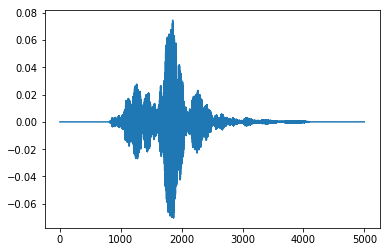

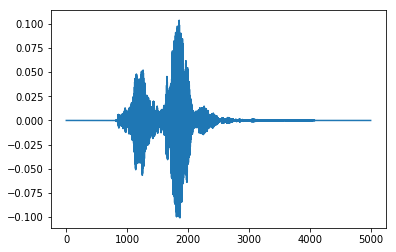

In [7]:
plt.plot(observation[0][:5000])
plt.show()
plt.plot(observation[1][:5000])
plt.show()

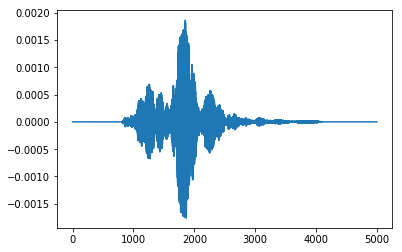

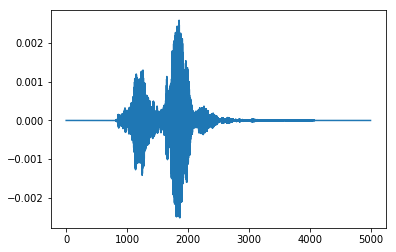

In [8]:
plt.plot(observation[0][:5000]/40)
plt.show()
plt.plot(observation[1][:5000]/40)
plt.show()

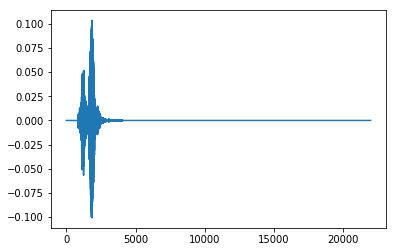

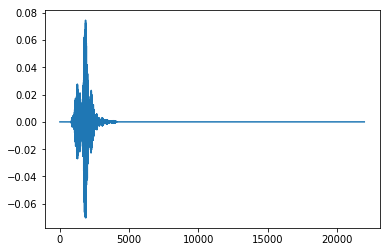

the state_type of the observation <class 'numpy.ndarray'> (5000,)


In [9]:
plt.plot(observation[1])
plt.show()
plt.plot(observation[0])
plt.show()
state_Type = type(observation[1][:5000])
print("the state_type of the observation", state_Type , observation[1][:5000].shape)

In [10]:
#conv on the echo pulse
a = torch.from_numpy(observation[1]).view(1,-1,1).float()
print("the a tensor", a.size())
a1 = torch.from_numpy(observation[0][:5000]).view(1,1,-1).float()
print("the a1 tensor", a1.size())

a1_right = torch.from_numpy(observation[1][:5000]).view(1,1,-1).float()
print("the a1 tensor", a1_right.size())


print(a.size())
m = nn.Conv1d(1, 100, kernel_size = 4 , stride = 3 , padding = 5 ) 
out = m(a1)
print("out size",out.size())
print("covolutional layer",m)

the a tensor torch.Size([1, 21985, 1])
the a1 tensor torch.Size([1, 1, 5000])
the a1 tensor torch.Size([1, 1, 5000])
torch.Size([1, 21985, 1])
out size torch.Size([1, 100, 1669])
covolutional layer Conv1d(1, 100, kernel_size=(4,), stride=(3,), padding=(5,))


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [20]:
class QNetworkCNN_1D_BATBOT(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64 , dropout = 0.1 , augment_frames = 3 ):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetworkCNN_1D_BATBOT, self).__init__()
        self.seed = torch.manual_seed(seed = seed)
        self.conv1_left = nn.Conv1d(augment_frames, 128, kernel_size = 128 , stride=5, padding=1)
        self.conv1bnorm_left = nn.BatchNorm1d(128)
        self.conv2_left = nn.Conv1d(128, 64, kernel_size = 16, stride=2, padding=1)
        self.conv2bnorm_left = nn.BatchNorm1d(64)
        self.conv3_left = nn.Conv1d(64, 64, kernel_size = 5, stride=1, padding=1)
        self.conv3bnorm_left = nn.BatchNorm1d(64)
        self.dropout_left = nn.Dropout(dropout)
        self.pool_left = nn.MaxPool1d(kernel_size = 4, stride = 4 )
        
        self.conv1_right = nn.Conv1d(augment_frames, 128, kernel_size= 128, stride=5, padding=1)
        self.conv1bnorm_right = nn.BatchNorm1d(128)
        self.conv2_right = nn.Conv1d(128, 64, kernel_size = 16, stride=2, padding=1)
        self.conv2bnorm_right = nn.BatchNorm1d(64)
        self.conv3_right = nn.Conv1d(64, 64, kernel_size = 5, stride=1, padding=1)
        self.conv3bnorm_right = nn.BatchNorm1d(64)
        self.dropout_right = nn.Dropout(dropout)
        self.pool_right = nn.MaxPool1d(kernel_size = 4, stride = 4 )
        
        # this needs to be changed accordingly
        self.in_linear = 6*64
        
        self.fc1 = nn.Linear(2*self.in_linear, fc1_units)
        self.fc1bnorm = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units,  fc2_units)
        self.fc2bnorm = nn.BatchNorm1d(fc2_units)
        self.fc2d = nn.Linear(fc2_units,  fc2_units)
        self.fc2dbnorm = nn.BatchNorm1d(fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.dropout = nn.Dropout(dropout) 

    def forward(self, left_state, right_state):
        """Build a network that maps state -> action values."""
        x1 = self.conv1_left(left_state)
        x1 = self.conv1bnorm_left(x1)
        x1 = F.relu(x1)
        x1 = self.pool_left(x1)
        x1 = self.conv2_left(x1)
        x1 = self.conv2bnorm_left(x1)
        x1 = F.relu(x1)
        x1 = self.pool_left(x1)
        x1 = self.conv3_left(x1)
        x1 = self.conv3bnorm_left(x1)
        x1 = F.relu(x1)
        x1 = self.pool_left(x1)
        
        x2 = self.conv1_right(right_state)
        x2 = self.conv1bnorm_right(x2)
        x2 = F.relu(x2)
        x2 = self.pool_right(x2)
        x2 = self.conv2_right(x2)
        x2 = self.conv2bnorm_right(x2)
        x2 = F.relu(x2)
        x2 = self.pool_right(x2)
        x2 = self.conv3_right(x2)
        x2 = self.conv3bnorm_right(x2)
        x2 = F.relu(x2)
        x2 = self.pool_right(x2)
        
        
        
        #print(x.size())
        x1 = x1.view(-1,self.in_linear)
        x2 = x2.view(-1,self.in_linear)
        x = torch.cat((x1,x2)).view(-1, 2*self.in_linear)
        #print(x.size())
        x = self.fc1(x)
        x = self.fc1bnorm(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.fc2bnorm(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2d(x)
        x = self.fc2dbnorm(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        return self.fc3(x)

In [ ]:
# this uses the lower diemensional data 
# energies of the echo from the left and right hear 
class QNetworkANN_BATBOT(nn.Module):
    def __init__(self, state_size , action_size , seed, fc1_units=64, fc2_units=64 ,fc3_units = 64, dropout = 0.3, augment_frames = 3);
        super(QNetworkANN_BATBOT, self).__init__()
        self.in_linear = 2*state_size*augment_frames
        # LAYER 1 - input layer
        self.fc1 = nn.Linear(self.in_linear , fc1_units)
        self.fc1bnorm = nn.BatchNorm1d(fc1_units)
        # HIDDEN LAYER 1
        self.fc2 = nn.Linear(fc1_units,fc2_units)
        self.fc2bnorm = nn.BatchNorm1d(fc2_units)
        # HIDDEN LAYER 2
        self.fc3 = nn.Linear(fc2_units,fc3_units)
        self.fc3bnorm = nn.BatchNorm1d(fc3_units)
        # OUTPUT LAYER
        self.fc4 = nn.Linear(fc3_units, action_size)
        #DROPOUT
        self.dropout = nn.Dropout(dropout) 
    def forward(self, left_state , right_state)
        #joining the left ear and right ear
        x = torch.cat((left_state,right_state)).view(-1, self.in_linear)
        #INPUT BLOCK
        x = self.fc1(x)
        x = self.fc1bnorm(x)
        x = F.relu(x)
        x = self.dropout(x)
        #LAYEr 1 BLOCK
        x = self.fc2(x)
        x = self.fc2bnorm(x)
        x = F.relu(x)
        x = self.dropout(x)
        #LAYER 2 BLOCK
        x = self.fc3(x)
        x = self.fc3bnorm(x)
        x = F.relu(x)
        x = self.dropout(x)
        # OUTPUT BLOCK
        return self.fc4(x)
    

In [21]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128       # minibatch size
GAMMA = 0.99           # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 1e-4               # learning rate 

WeightDecay = 0

UPDATE_EVERY = 1      # how often to update the network
N_Update_per = 2 # no of updates per time

Momentum = 0.9  
Epislon = 0.99
min_Epislon = 0.001

Decay = 0.999
MaxBeta = 1
MinBeta = 0


ALPHA = 0.5
ALPHA2 = 1
ALPHA_min = 0.01
Alphadecay = 0.999 
ErrorOffset = 0.01
min_beta = 0.3

In [22]:
action_size = 3
score = 0 # initialize the score
i = 3
while i > 0:
    action = np.random.randint(action_size)                 # select an action
    observation, reward, done, info = env.step(action)      # send the action to the environment
    next_state = observation                                # see if episode has finished
    if (len(observation[0])<5000): 
        print("bug handled")
        print(len(observation[0]))
        plt.plot(observation[0])
        plt.show()
        break
        #observation =  (handling_echo_bug(observation[0]), handling_echo_bug(observation[1]))
        #print(len(observation[0]))
    assert(len(observation[0])>=5000)
    score += reward                                         # update the score
    state = next_state                                      # roll over the state to next time step
    i-=1
    if done:                                                # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.01


In [23]:
qnetwork_local = QNetworkCNN_1D_BATBOT(a1.size(), 3, seed=0, augment_frames = 3).to(device)
print(qnetwork_local)

QNetworkCNN_1D_BATBOT(
  (conv1_left): Conv1d(3, 128, kernel_size=(128,), stride=(5,), padding=(1,))
  (conv1bnorm_left): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_left): Conv1d(128, 64, kernel_size=(16,), stride=(2,), padding=(1,))
  (conv2bnorm_left): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_left): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(1,))
  (conv3bnorm_left): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_left): Dropout(p=0.1, inplace=False)
  (pool_left): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv1_right): Conv1d(3, 128, kernel_size=(128,), stride=(5,), padding=(1,))
  (conv1bnorm_right): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_right): Conv1d(128, 64, kernel_size=(16,), stride=(2,), padding=(1,))
  (conv2bnorm_right): BatchNorm1d(64, eps=

In [24]:
a2 = torch.cat((a1, a1_right,a1)).view(1,3,-1).float().to(device)
az = torch.cat((a2,a2,a2,a2,a2,a2)).view(6,3,-1).float().to(device)
print(a1.size(),"augmented", a2.size())
print(az.size())
out = qnetwork_local(az, az)
print("out", out)
print(out.size())


torch.Size([1, 1, 5000]) augmented torch.Size([1, 3, 5000])
torch.Size([6, 3, 5000])
out tensor([[-0.2387,  0.1349, -0.1015],
        [ 0.0076,  0.2518,  0.1076],
        [ 0.3704,  0.1894,  0.2099],
        [ 0.5601,  0.1686, -0.4052],
        [ 0.0879,  0.2729, -0.2401],
        [ 0.0335, -0.2147, -0.2175]], device='cuda:0', grad_fn=<AddmmBackward>)
torch.Size([6, 3])


In [25]:
import numpy as np
import random
from collections import namedtuple, deque
from queue import PriorityQueue

# from model import QNetwork
# from model import QNetworkCNN
from torch.autograd import Variable

import torch
import torch.nn.functional as F
import torch.optim as optim

In [26]:
obs = np.zeros(100)
print(len(obs))
obs = handling_echo_bug(obs)
print(obs.shape)

100


NameError: name 'handling_echo_bug' is not defined

In [27]:
print(type(observation[0][:5000]))
test_agent = Agent(observation[1][:5000].shape, 4 , state_Type , seed =0)
for i in range(80):
    test_agent.step([observation[1][:5000],observation[1][:5000]], 3, 1, [observation[1][:5000],observation[1][:5000]], False)
print("test_memory added to the replay buffer" , len(test_agent.memory.memory))
print("the sampled memory for learning", np.shape(test_agent.memory.sample_idx()[0]), test_agent.memory.sample_idx()[1][2])

<class 'numpy.ndarray'>


NameError: name 'Agent' is not defined

In [28]:
a  = test_agent.memory.sample_idx(peek_a_boo= True)
print(a[0][:,0,0].shape)
plt.plot(a[0][0,2,1].cpu().numpy())

NameError: name 'test_agent' is not defined

In [29]:
print(type(observation[0]), len(test_agent.memory.memory),observation[0][:5000])
action = test_agent.act([observation[0][:5000],observation[1][:5000]])
print("the test agent action selection is passed", action)

NameError: name 'test_agent' is not defined

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device which is used is " , device)

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, state_type,seed,signal = "echo", augment_states_T=3 ):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
            Beta is for sacling down the weights update due to the Priority Queues
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.Beta = 1
        self.Gamma = GAMMA
        self.augment_time =  augment_states_T

        # Q-Network
        if(signal == "echo"):
            self.qnetwork_local = QNetworkCNN_1D_BATBOT(state_size, action_size, seed , augment_frames =  augment_states_T).to(device)
            self.qnetwork_target = QNetworkCNN_1D_BATBOT(state_size, action_size, seed , augment_frames =  augment_states_T).to(device)
        else:
            print("do your thesis dude ...Wtf! r u doing ")
            
            
        print("the model is defined successfully", self.qnetwork_target)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR , weight_decay= WeightDecay)
        self.state_type = state_type
        # Replay memory
        #self.memory = PriorityReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE,ALPHA,state_type, seed)
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        #Priority = self.getError(state, action, reward, next_state,done)
        #self.memory.add(state, action, reward, next_state, done,Priority)
        #self, state, action, reward, next_state, done
        self.memory.add(state, action, reward, next_state,done)
        global Epislon
        Epislon *= Decay
        if(Epislon < min_Epislon):
            Epislon = min_Epislon
        beta = 1 - Epislon
        #print(beta)
        # alpha value for priority buffer
        global ALPHA2
        ALPHA2 *= Alphadecay
        if(ALPHA2 < ALPHA_min):
            ALPHA2 = ALPHA_min
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE*3:
                #uncomment this for priority buffer
                #experiences = self.memory.sample(ALPHA2,beta)
                for _ in range(N_Update_per):
                    experiences = self.memory.sample_idx()
                    self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        
        #state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # if e is not None and e[1].done != True and 
        # self.memory[e[0]-1].done != True and e[0]-1 > 0 and e[0] < len(agent.memory.memory)-1])
        if (len(self.memory.memory) >= 2 and (self.memory.memory[-1].done or self.memory.memory[-2].done) == False):
            #print(np.dtype(state), np.size(state))
            #print(len(self.memory.memory), [self.memory.memory[-2].state[0],self.memory.memory[-1].state[0],state])
            left_state = torch.from_numpy(np.array([self.memory.memory[-2].state[0],self.memory.memory[-1].state[0],state[0]]).astype(np.float32)).float().view(1,self.augment_time,-1).to(device)
            
            right_state = torch.from_numpy(np.array([self.memory.memory[-2].state[1],self.memory.memory[-1].state[1],state[1]])).float().view(1,self.augment_time,-1).to(device)
            #print(state.size())
            self.qnetwork_local.eval()
            #print(np.size(state))
            with torch.no_grad():
                action_values = self.qnetwork_local(left_state, right_state)
            #print(action_values)
            self.qnetwork_local.train()
            #for debuging
            #check =    random.choice(np.arange(self.action_size))
            #check2 = np.argmax(action_values.cpu().data.numpy())
            #print(check.dtype , check2.dtype)
            # Epsilon-greedy action selection
            if random.random() > eps:
                return np.argmax(action_values.cpu().data.numpy() , )
            else:
                return random.choice(np.arange(self.action_size))
        else:
            return random.choice(np.arange(self.action_size))
            
                   

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        # uncomment this line if u wanna use priority Buffer
        #states, actions, rewards, next_states, dones, weights = experiences
        states, actions, rewards, next_states, dones = experiences
        #print(states.size())
        size_now = states.size()
        #print("size_now",size_now[0], states[:,:,0,:].size(),self.augment_time)
        #  To Do .. code needs change Data set differs
        # last one needs to be the length of the echo
        left_states = states[:,:,0,:].view(size_now[0] , self.augment_time , -1)
        right_states = states[:,:,1,:].view(size_now[0] , self.augment_time , -1)
        left_next_states = next_states[:,:,0,:].view(size_now[0] , self.augment_time , -1)
        right_next_states = next_states[:,:,1,:].view(size_now[0] , self.augment_time , -1)
        # Get max predicted Q values (for next states) from target model
        #getting the maximum action from the Q table and applying it in the 
        #print("states size" , next_states.size())
        #------this for DDQN ---- uncomment this for DDQN-------------------------
        Q_targets_next_action = self.qnetwork_local(left_next_states , right_next_states).detach().argmax(1).unsqueeze(1)
        #print(Q_targets_next_action)
        Q_targets_next = self.qnetwork_target(left_next_states , right_next_states).gather(1 , Q_targets_next_action)
        Q_targets_next = Q_targets_next.detach()
        # Compute Q targets for current states 
        # Compute Q targets for current states 
        #print(Q_targets_next.size())
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(left_states, right_states).gather(1, actions)
        #print("expected", Q_expected.size())
        #print("expected" , Q_expected , Q_targets)
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # change reduce to False for priority buffer
        
        #loss = F.smooth_l1_loss(Q_expected, Q_targets)
        #print(loss.size())
        
        # this removed due to the swtching to normal replay buffer
        #loss = loss * (weights).detach()
        #loss = torch.mean(loss)
        #loss has to be scaled scaled down by weights = (1 /(N*p(i)))^Beta
        #loss = F.l1_loss(Q_expected , Q_targets)
        
        #print("The Loss", loss)
        # Minimize the loss
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        
        

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)
        
#         ##-- for updating the priorities in the experience replay buffer------###
#         with torch.no_grad():
#             Q_targets_next_action = self.qnetwork_local(next_states).detach().max(1)[1].unsqueeze(1)
#             #print(Q_targets_next_action)
#             Q_targets_next = self.qnetwork_target(next_states).gather(1 , Q_targets_next_action)
#             Q_targets_next = Q_targets_next.detach()
#             # Compute Q targets for current states 
#             Q_targets = rewards + (gamma * Q_targets_next * (1 - dones)).detach()

#             # Get expected Q values from local model
#             Q_expected = self.qnetwork_local(states).gather(1, actions).detach()

#             errors = torch.abs(Q_expected - Q_targets).cpu().data.numpy()
#             self.memory.updatePriorities(errors)
        
        
        
    def ConvnumpyTotorch(self,states, actions, rewards, next_states, dones):
        # converts the numpy to tensor variables
        states = torch.from_numpy(np.array([states])).float().to(device)
        actions = torch.from_numpy(np.array([[actions]])).long().to(device)
        rewards = torch.from_numpy(np.array([rewards])).float().to(device)
        next_states = torch.from_numpy(np.array([next_states])).float().to(device)
        dones = torch.from_numpy(np.array([dones]).astype(np.uint8)).float().to(device)
        return states, actions, rewards, next_states, dones
        
    def getError(self,states, actions, rewards, next_states, dones):
        
        with torch.no_grad():
            #print("states" , states.shape , next_states.shape)
            states, actions, rewards, next_states, dones = self.ConvnumpyTotorch(states, actions, rewards, next_states, dones)
            #print("states",states , next_states)
            Q_targets_next_action = self.qnetwork_local(next_states).detach().max(1)[1].unsqueeze(1)
            #print("actions",Q_targets_next_action , actions)
            #print(next_states.shape)
            Q_targets_next = self.qnetwork_target(next_states).gather(1 , Q_targets_next_action)
            Q_targets_next = Q_targets_next.detach()
            # Compute Q targets for current states 
            Q_targets = rewards + (GAMMA * Q_targets_next * (1 - dones))

            # Get expected Q values from local model

            Q_expected = self.qnetwork_local(states).gather(1, actions)
            Q_expected = Q_expected.detach()
            #error =  F.l1_loss(Q_expected , Q_targets)
            error =  torch.abs(Q_expected - Q_targets).cpu().data.numpy()
        return (error.item() + ErrorOffset)
    
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples. 
    Also can be used to store the priortized tuples"""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            Priority(float):
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.selectedIdx = np.array([])
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        #print(experiences[0])
        states = torch.from_numpy(np.stack([e.state for e in experiences if e is not None] , axis =0 )).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None], axis =0)).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)
    def sample_idx(self , peek_a_boo = False):
        if peek_a_boo == True:
            batch_size = 1
        else:
            batch_size = self.batch_size
        index_value = random.sample(list(enumerate(self.memory)), k= batch_size)
        #print("batch", self.batch_size)
        states = torch.from_numpy(np.stack([[self.memory[e[0]-2].state,self.memory[e[0]-1].state ,e[1].state] for e in index_value if e is not None and e[1].done != True and self.memory[e[0]-1].done != True and e[0]-1 > 0 and e[0] < len(self.memory)-1] , axis = 0 )).float().to(device)
        actions = torch.from_numpy(np.vstack([e[1].action for e in index_value if e is not None and e[1].done != True and self.memory[e[0]-1].done != True and e[0]-1 > 0 and e[0] < len(self.memory)-1])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e[1].reward for e in index_value if e is not None and e[1].done != True and self.memory[e[0]-1].done != True and e[0]-1 > 0 and e[0] < len(self.memory)-1])).float().to(device)
        next_states = torch.from_numpy(np.stack([[self.memory[e[0]-2].next_state, self.memory[e[0]-1].next_state ,e[1].next_state] for e in index_value if e is not None and e[1].done != True and self.memory[e[0]-1].done != True and e[0]-1 > 0 and e[0] < len(self.memory)-1] , axis = 0 )).float().to(device)
        dones = torch.from_numpy(np.vstack([e[1].done for e in index_value if e is not None and e[1].done != True and self.memory[e[0]-1].done != True and e[0]-1 > 0 and e[0] < len(self.memory)-1]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def sample_idx_withBatch(self , batch_size , peek_a_boo = False):
        
        if peek_a_boo == True:
            batch_size = 1
        index_value = random.sample(list(enumerate(self.memory)), k=batch_size)
        states = torch.from_numpy(np.stack([[self.memory[e[0]-1].state ,e[1].state] for e in index_value if e is not None and e[1].done != True and self.memory[e[0]-1].done != True] , axis = 0 )).float().to(device)
        actions = torch.from_numpy(np.vstack([e[1].action for e in index_value if e is not None and e[1].done != True and self.memory[e[0]-1].done != True])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e[1].reward for e in index_value if e is not None and e[1].done != True and self.memory[e[0]-1].done != True])).float().to(device)
        next_states = torch.from_numpy(np.stack([[self.memory[e[0]-1].state ,e[1].state] for e in index_value if e is not None and e[1].done != True and self.memory[e[0]-1].done != True] , axis = 0 )).float().to(device)
        dones = torch.from_numpy(np.vstack([e[1].done for e in index_value if e is not None and e[1].done != True and self.memory[e[0]-1].done != True]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    
    
        



    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
class PriorityReplayBuffer:
    """Fixed-size buffer to store experience tuples. 
    Also can be used to store the priortized tuples"""

    def __init__(self, action_size, buffer_size, batch_size, alpha, state_type ,  seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            Priority(float):
            seed (int): random seed
        """
        self.action_size = action_size
        self.Prioritymemory = deque(maxlen=buffer_size) 
        self.batch_size = batch_size
        self.expType = [('state',state_type), ('action','float'),('reward','float'), ('next_state',state_type),('done','bool'),('Priority','float')]
        self.experienceMemory = np.array([], dtype = self.expType)
        self.seed = random.seed(seed)
        self.max_size = buffer_size
        self.alpha = alpha
        
    
    def add(self, state, action, reward, next_state, done, Priority):
        """Add a new experience to memory."""
        if(np.size(self.experienceMemory) > self.max_size):
            self.experienceMemory = np.delete(self.experienceMemory , 0 )
        e = (state, action, reward, next_state, done, Priority)
        exp = np.array([e] , dtype = self.expType)
        self.experienceMemory = np.append(self.experienceMemory , exp )
        #print("memory", np.shape(self.experienceMemory['state'][0]))
        #self.memory.append(e)
    
    def sample(self , alpha , beta):
        """ sample a batch of experiences from memory. based on the Priority"""
        # write ur own implementation
        self.alpha = alpha
        self.beta = beta
        if(self.beta < min_beta):
            self.beta = min_beta
        probs ,Choosenindex = self.Batchsample()
        self.selectedIdx = Choosenindex
        weights = (np.size(self.experienceMemory)* probs)**(-(self.beta))
        weights /= np.max(weights)
        weights = Variable(torch.from_numpy(np.vstack(weights)).float().to(device))
        states = Variable(torch.from_numpy(np.stack(self.experienceMemory['state'][Choosenindex] , axis =0)).float().to(device))
        #print("at sampling",states.size())
        actions = Variable(torch.from_numpy(np.vstack(self.experienceMemory['action'][Choosenindex])).long().to(device))
        rewards = Variable(torch.from_numpy(np.vstack(self.experienceMemory['reward'][Choosenindex])).float().to(device))
        next_states = Variable(torch.from_numpy(np.stack(self.experienceMemory['next_state'][Choosenindex] , axis =0)).float().to(device))
        dones = Variable(torch.from_numpy(np.vstack(self.experienceMemory['done'][Choosenindex]).astype(np.uint8)).float().to(device))
        
        
  
        return (states, actions, rewards, next_states, dones , weights)
    
    def Batchsample(self):
        """Samples the batch here """
        all_priorities = self.experienceMemory['Priority']
        probs = self.GetProbs(all_priorities)
        indeArr = np.arange(len(probs))
        Choosenindex = np.random.choice(indeArr, self.batch_size,p=probs, replace = False)
        return probs[Choosenindex] , Choosenindex
    
    def GetProbs(self, Pri):
        """ Probabilities are defiend here"""
        Numerator = np.power(Pri, self.alpha)
        Demoninator = np.sum(Numerator)
        Probs = Numerator / Demoninator
        return Probs
    
    def updatePriorities(self,Error):
        #print(self.selectedIdx , Error , np.size(Error) , np.size(self.selectedIdx))
        self.experienceMemory['Priority'][self.selectedIdx] = Error.flatten()
                                    
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.experienceMemory)

def handling_echo_bug(echo , size = 5000):
    state = np.zeros(5000)
    state[:len(echo)] = echo
    return state

Device which is used is  cuda:0


In [31]:
# test_obs , echo_time  = env.get_observationEnv() 
# print(len(test_obs))

In [32]:
agent = Agent(observation[1][:5000].shape, 3 , state_Type , seed =0)

the model is defined successfully QNetworkCNN_1D_BATBOT(
  (conv1_left): Conv1d(3, 128, kernel_size=(128,), stride=(5,), padding=(1,))
  (conv1bnorm_left): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_left): Conv1d(128, 64, kernel_size=(16,), stride=(2,), padding=(1,))
  (conv2bnorm_left): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_left): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(1,))
  (conv3bnorm_left): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_left): Dropout(p=0.1, inplace=False)
  (pool_left): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv1_right): Conv1d(3, 128, kernel_size=(128,), stride=(5,), padding=(1,))
  (conv1bnorm_right): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_right): Conv1d(128, 64, kernel_size=(16,), stride=(2,), padding=(1,))
  (conv2

In [33]:
env.reset()

(array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]))

In [34]:
saving_episode = 105 
next_saving = 50
saving_score = 1.5
next_saving_score = 1
norm_max = 40

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 1	Average Score: -2.46Maxi 289
Episode 2	Average Score: -2.68Maxi 299
Episode 3	Average Score: -2.66Maxi 299
Episode 4	Average Score: -2.74Maxi 299
Episode 5	Average Score: -2.74Maxi 299
Episode 6	Average Score: -2.69Maxi 299
Episode 7	Average Score: -2.69Maxi 299
Episode 8	Average Score: -2.72Maxi 299
Episode 9	Average Score: -2.72Maxi 299
Episode 10	Average Score: -2.69Maxi 299
Episode 10	Average Score: -2.69


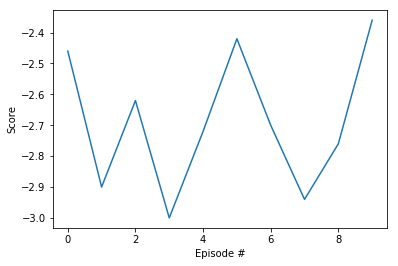

Episode 11	Average Score: -2.66Maxi 299
Episode 12	Average Score: -2.65Maxi 299
Episode 13	Average Score: -2.68Maxi 299
Episode 14	Average Score: -2.68Maxi 299
Episode 15	Average Score: -2.70Maxi 299
Episode 16	Average Score: -2.70Maxi 299
Episode 17	Average Score: -2.70Maxi 299
Episode 18	Average Score: -2.68Maxi 299
Episode 19	Average Score: -2.66Maxi 299
Episode 20	Average Score: -2.66Maxi 299
Episode 20	Average Score: -2.66


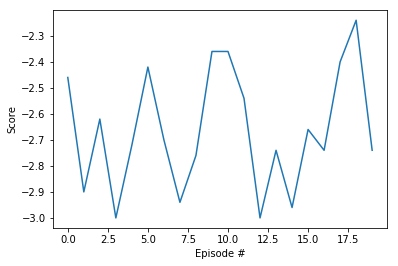

Episode 21	Average Score: -2.68Maxi 299
Episode 22	Average Score: -2.65Maxi 299
Episode 23	Average Score: -2.63Maxi 299
Episode 24	Average Score: -2.63Maxi 299
Episode 25	Average Score: -2.63Maxi 299
Episode 26	Average Score: -2.61Maxi 299
Episode 27	Average Score: -2.62Maxi 299
Episode 28	Average Score: -2.64Maxi 299
Episode 29	Average Score: -2.62Maxi 299
Episode 30	Average Score: -2.62Maxi 299
Episode 30	Average Score: -2.62


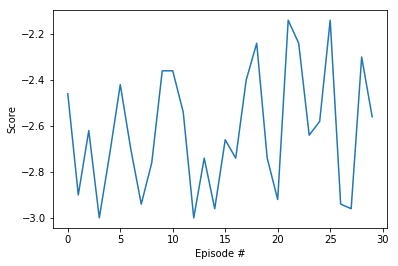

Episode 31	Average Score: -2.62Maxi 299
Episode 32	Average Score: -2.63Maxi 299
Episode 33	Average Score: -2.62Maxi 299
Episode 34	Average Score: -2.62Maxi 299
Episode 35	Average Score: -2.63Maxi 299
Episode 36	Average Score: -2.61Maxi 299
Episode 37	Average Score: -2.62Maxi 299
Episode 38	Average Score: -2.62Maxi 299
Episode 39	Average Score: -2.62Maxi 299
Episode 40	Average Score: -2.62Maxi 299
Episode 40	Average Score: -2.62


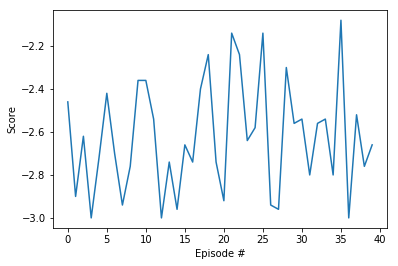

Episode 41	Average Score: -2.62Maxi 299
Episode 42	Average Score: -2.63Maxi 299
Episode 43	Average Score: -2.62Maxi 299
Episode 44	Average Score: -2.62Maxi 299
Episode 45	Average Score: -2.62Maxi 299
Episode 46	Average Score: -2.63Maxi 299
Episode 47	Average Score: -2.62Maxi 299
Episode 48	Average Score: -2.62Maxi 299
Episode 49	Average Score: -2.63Maxi 299
Episode 50	Average Score: -2.63Maxi 299
Episode 50	Average Score: -2.63


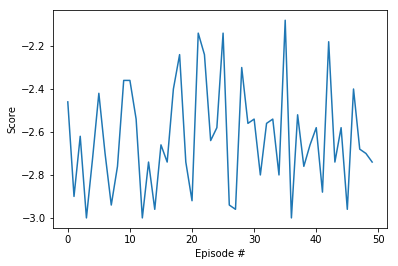

Episode 51	Average Score: -2.63Maxi 299
Episode 52	Average Score: -2.63Maxi 299
Episode 53	Average Score: -2.64Maxi 299
Episode 54	Average Score: -2.63Maxi 299
Episode 55	Average Score: -2.62Maxi 299
Episode 56	Average Score: -2.62Maxi 299
Episode 57	Average Score: -2.63Maxi 299
Episode 58	Average Score: -2.61Maxi 299
Episode 59	Average Score: -2.62Maxi 299
Episode 60	Average Score: -2.63Maxi 299
Episode 60	Average Score: -2.63


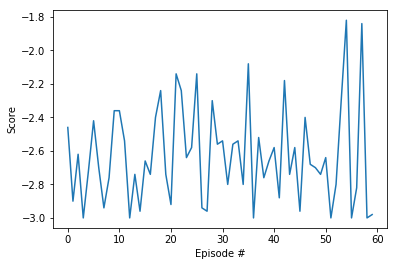

Episode 61	Average Score: -2.63Maxi 299
Episode 62	Average Score: -2.63Maxi 299
Episode 63	Average Score: -2.63Maxi 299
Episode 64	Average Score: -2.63Maxi 299
Episode 65	Average Score: -2.63Maxi 299
Episode 66	Average Score: -2.63Maxi 299
Episode 67	Average Score: -2.63Maxi 299
Episode 68	Average Score: -2.63Maxi 299
Episode 69	Average Score: -2.63Maxi 299
Episode 70	Average Score: -2.63Maxi 299
Episode 70	Average Score: -2.63


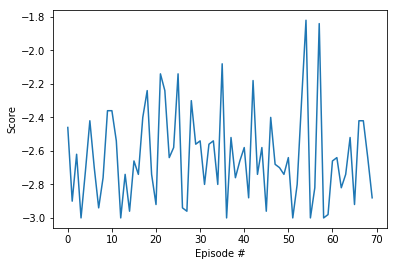

Episode 71	Average Score: -2.63Maxi 299
Episode 72	Average Score: -2.63Maxi 299
Episode 73	Average Score: -2.63Maxi 299
Episode 74	Average Score: -2.64Maxi 299
Episode 75	Average Score: -2.63Maxi 299
Episode 76	Average Score: -2.63Maxi 299
Episode 77	Average Score: -2.63Maxi 299
Episode 78	Average Score: -2.62Maxi 299
Episode 79	Average Score: -2.63Maxi 299
Episode 80	Average Score: -2.62Maxi 299
Episode 80	Average Score: -2.62


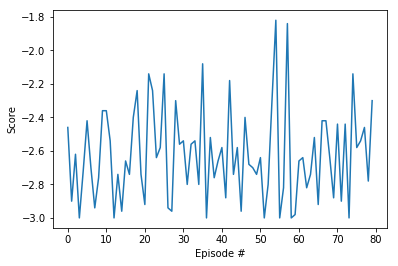

Episode 81	Average Score: -2.62Maxi 299
Episode 82	Average Score: -2.62Maxi 299
Episode 83	Average Score: -2.63Maxi 299
Episode 84	Average Score: -2.62Maxi 299
Episode 85	Average Score: -2.62Maxi 299
Episode 86	Average Score: -2.63Maxi 299
Episode 87	Average Score: -2.62Maxi 299
Episode 88	Average Score: -2.62Maxi 299
Episode 89	Average Score: -2.62Maxi 299
Episode 90	Average Score: -2.62Maxi 299
Episode 90	Average Score: -2.62


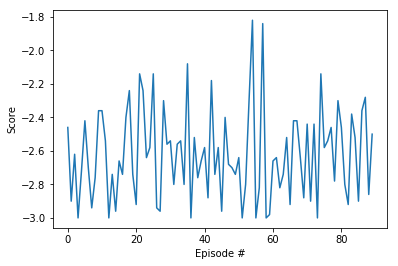

Episode 91	Average Score: -2.61Maxi 299
Episode 92	Average Score: -2.62Maxi 299
Episode 93	Average Score: -2.62Maxi 299
Episode 94	Average Score: -2.61Maxi 299
Episode 95	Average Score: -2.62Maxi 299
Episode 96	Average Score: -2.62Maxi 299
Episode 97	Average Score: -2.62Maxi 299
Episode 98	Average Score: -2.62Maxi 299
Episode 99	Average Score: -2.62Maxi 299
Episode 100	Average Score: -2.62Maxi 299
Episode 100	Average Score: -2.62


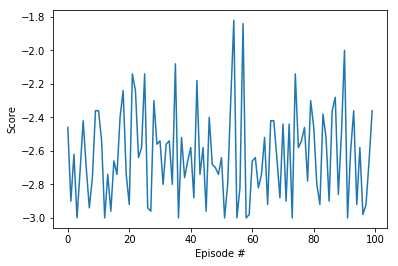

Episode 100	Average Score: -2.62


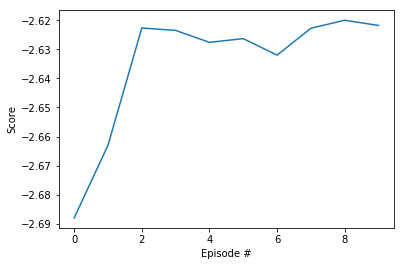

Episode 101	Average Score: -2.63Maxi 299
Episode 102	Average Score: -2.62Maxi 299
Episode 103	Average Score: -2.62Maxi 299
Episode 104	Average Score: -2.62Maxi 299

Environment solved in 5 episodes!	Average Score: -2.62
Episode 105	Average Score: -2.62Maxi 299
Episode 106	Average Score: -2.62Maxi 299
Episode 107	Average Score: -2.62Maxi 299
Episode 108	Average Score: -2.62Maxi 299
Episode 109	Average Score: -2.62Maxi 299
Episode 110	Average Score: -2.62Maxi 299
Episode 110	Average Score: -2.62


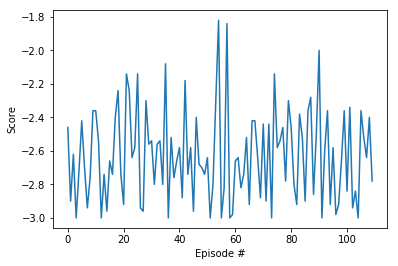

Episode 111	Average Score: -2.62Maxi 299
Episode 112	Average Score: -2.62Maxi 299
Episode 113	Average Score: -2.62Maxi 299
Episode 114	Average Score: -2.61Maxi 299
Episode 115	Average Score: -2.61Maxi 299
Episode 116	Average Score: -2.61Maxi 299
Episode 117	Average Score: -2.61Maxi 299
Episode 118	Average Score: -2.62Maxi 299
Episode 119	Average Score: -2.62Maxi 299
Episode 120	Average Score: -2.62Maxi 299
Episode 120	Average Score: -2.62


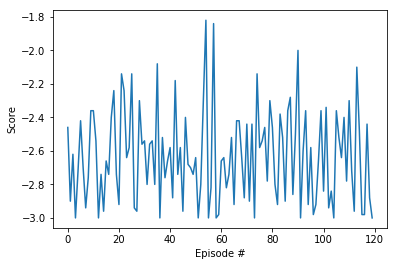

Episode 121	Average Score: -2.62Maxi 299
Episode 122	Average Score: -2.62Maxi 299
Episode 123	Average Score: -2.63Maxi 299
Episode 124	Average Score: -2.63Maxi 299
Episode 125	Average Score: -2.63Maxi 299
Episode 126	Average Score: -2.64Maxi 299
Episode 127	Average Score: -2.63Maxi 299
Episode 128	Average Score: -2.63Maxi 299
Episode 129	Average Score: -2.63Maxi 299
Episode 130	Average Score: -2.64Maxi 299
Episode 130	Average Score: -2.64


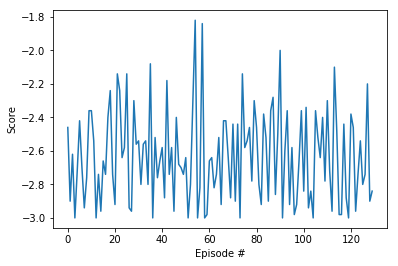

Episode 131	Average Score: -2.64Maxi 299
Episode 132	Average Score: -2.64Maxi 299
Episode 133	Average Score: -2.64Maxi 299
Episode 134	Average Score: -2.64Maxi 299
Episode 135	Average Score: -2.64Maxi 299
Episode 136	Average Score: -2.64Maxi 299
Episode 137	Average Score: -2.64Maxi 299
Episode 138	Average Score: -2.64Maxi 299
Episode 139	Average Score: -2.64Maxi 299
Episode 140	Average Score: -2.64Maxi 299
Episode 140	Average Score: -2.64


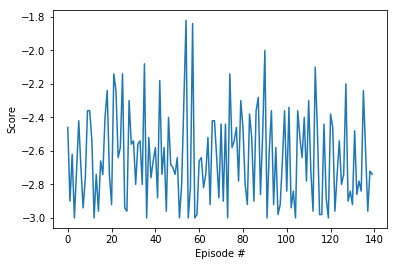

Episode 141	Average Score: -2.65Maxi 299
Episode 142	Average Score: -2.63Maxi 299
Episode 143	Average Score: -2.64Maxi 299
Episode 144	Average Score: -2.64Maxi 299
Episode 145	Average Score: -2.64Maxi 299
Episode 146	Average Score: -2.64Maxi 299
Episode 147	Average Score: -2.65Maxi 299
Episode 148	Average Score: -2.64Maxi 299
Episode 149	Average Score: -2.64Maxi 299
Episode 150	Average Score: -2.64Maxi 299
Episode 150	Average Score: -2.64


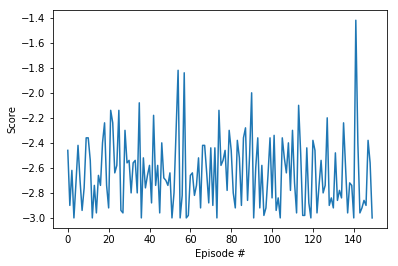

Episode 151	Average Score: -2.65Maxi 299
Episode 152	Average Score: -2.64Maxi 299
Episode 153	Average Score: -2.64Maxi 299
Episode 154	Average Score: -2.64Maxi 299

Environment solved in 55 episodes!	Average Score: -2.64
Episode 155	Average Score: -2.65Maxi 299
Episode 156	Average Score: -2.65Maxi 299
Episode 157	Average Score: -2.64Maxi 299
Episode 158	Average Score: -2.66Maxi 299
Episode 159	Average Score: -2.66Maxi 299
Episode 160	Average Score: -2.65Maxi 299
Episode 160	Average Score: -2.65


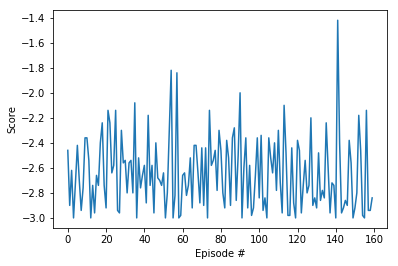

Episode 161	Average Score: -2.66Maxi 299
Episode 162	Average Score: -2.66Maxi 299
Episode 163	Average Score: -2.66Maxi 299
Episode 164	Average Score: -2.66Maxi 299
Episode 165	Average Score: -2.66Maxi 299
Episode 166	Average Score: -2.65Maxi 299
Episode 167	Average Score: -2.66Maxi 299
Episode 168	Average Score: -2.66Maxi 299
Episode 169	Average Score: -2.66Maxi 299
Episode 170	Average Score: -2.66Maxi 299
Episode 170	Average Score: -2.66


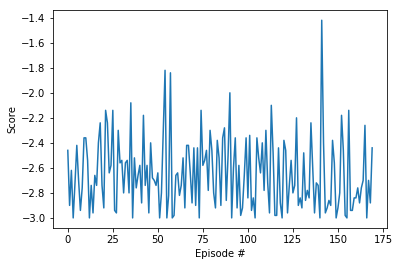

Episode 171	Average Score: -2.67Maxi 299
Episode 172	Average Score: -2.66Maxi 299
Episode 173	Average Score: -2.67Maxi 299
Episode 174	Average Score: -2.67Maxi 299
Episode 175	Average Score: -2.67Maxi 299
Episode 176	Average Score: -2.67Maxi 299
Episode 177	Average Score: -2.67Maxi 299
Episode 178	Average Score: -2.67Maxi 299
Episode 179	Average Score: -2.67Maxi 299
Episode 180	Average Score: -2.68Maxi 299
Episode 180	Average Score: -2.68


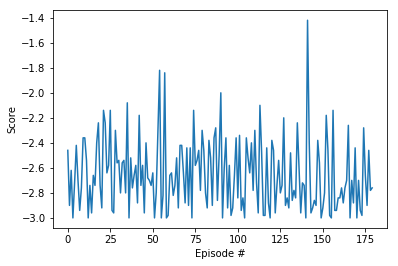

Episode 181	Average Score: -2.68Maxi 299
Episode 182	Average Score: -2.67Maxi 299
Episode 183	Average Score: -2.67Maxi 299
Episode 184	Average Score: -2.66Maxi 299
Episode 185	Average Score: -2.67Maxi 299
Episode 186	Average Score: -2.66Maxi 299
Episode 187	Average Score: -2.66Maxi 299
Episode 188	Average Score: -2.66Maxi 299
Episode 189	Average Score: -2.66Maxi 299
Episode 190	Average Score: -2.66Maxi 299
Episode 190	Average Score: -2.66


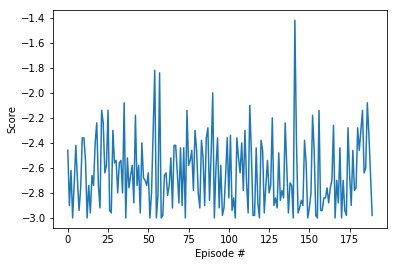

Episode 191	Average Score: -2.67Maxi 299
Episode 192	Average Score: -2.67Maxi 299
Episode 193	Average Score: -2.66Maxi 299
Episode 194	Average Score: -2.67Maxi 299
Episode 195	Average Score: -2.67Maxi 299
Episode 196	Average Score: -2.67Maxi 299
Episode 197	Average Score: -2.67Maxi 299
Episode 198	Average Score: -2.66Maxi 299
Episode 199	Average Score: -2.66Maxi 299
Episode 200	Average Score: -2.66Maxi 299
Episode 200	Average Score: -2.66


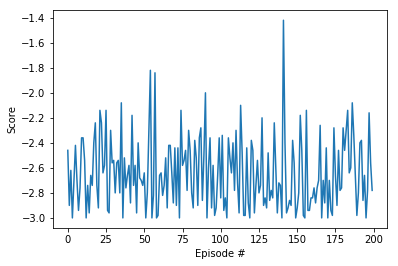

Episode 200	Average Score: -2.66


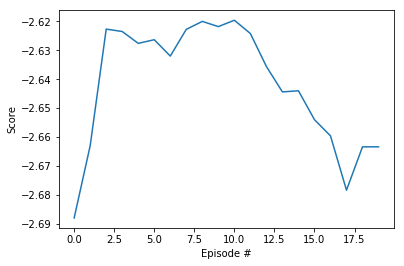

Episode 201	Average Score: -2.66Maxi 299
Episode 202	Average Score: -2.66Maxi 299
Episode 203	Average Score: -2.66Maxi 299
Episode 204	Average Score: -2.66Maxi 299

Environment solved in 105 episodes!	Average Score: -2.66
Episode 205	Average Score: -2.66Maxi 299
Episode 206	Average Score: -2.66Maxi 299
Episode 207	Average Score: -2.66Maxi 299
Episode 208	Average Score: -2.66Maxi 299
Episode 209	Average Score: -2.66Maxi 299
Episode 210	Average Score: -2.66Maxi 299
Episode 210	Average Score: -2.66


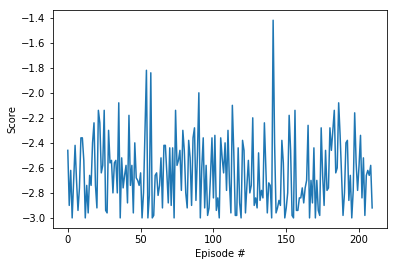

Episode 211	Average Score: -2.67Maxi 299
Episode 212	Average Score: -2.66Maxi 299
Episode 213	Average Score: -2.66Maxi 299
Episode 214	Average Score: -2.67Maxi 299
Episode 215	Average Score: -2.66Maxi 299
Episode 216	Average Score: -2.66Maxi 299
Episode 217	Average Score: -2.66Maxi 299
Episode 218	Average Score: -2.67Maxi 299
Episode 219	Average Score: -2.66Maxi 299
Episode 220	Average Score: -2.66Maxi 299
Episode 220	Average Score: -2.66


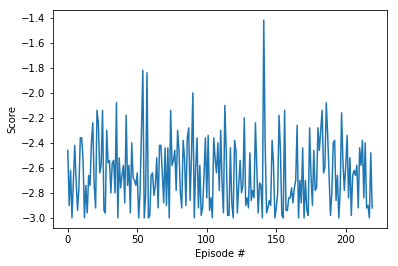

Episode 221	Average Score: -2.66Maxi 299
Episode 222	Average Score: -2.67Maxi 299
Episode 223	Average Score: -2.66Maxi 299
Episode 224	Average Score: -2.67Maxi 299
Episode 225	Average Score: -2.66Maxi 299
Episode 226	Average Score: -2.66Maxi 299
Episode 227	Average Score: -2.66Maxi 299
Episode 228	Average Score: -2.66Maxi 299
Episode 229	Average Score: -2.66Maxi 299
Episode 230	Average Score: -2.67Maxi 299
Episode 230	Average Score: -2.67


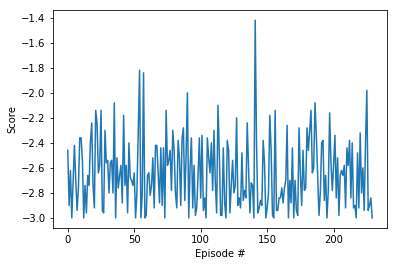

Episode 231	Average Score: -2.67Maxi 299
Episode 232	Average Score: -2.67Maxi 299
Episode 233	Average Score: -2.67Maxi 299
Episode 234	Average Score: -2.66Maxi 299
Episode 235	Average Score: -2.66Maxi 299
Episode 236	Average Score: -2.67Maxi 299
Episode 237	Average Score: -2.67Maxi 299
Episode 238	Average Score: -2.67Maxi 299
Episode 239	Average Score: -2.67Maxi 299
Episode 240	Average Score: -2.67Maxi 299
Episode 240	Average Score: -2.67


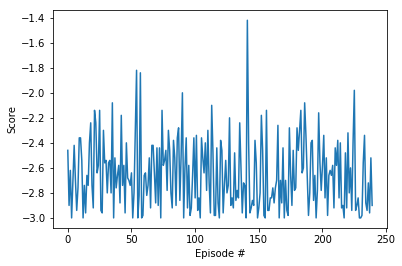

Episode 241	Average Score: -2.67Maxi 299
Episode 242	Average Score: -2.68Maxi 299
Episode 243	Average Score: -2.68Maxi 299
Episode 244	Average Score: -2.68Maxi 299
Episode 245	Average Score: -2.67Maxi 299
Episode 246	Average Score: -2.67Maxi 299
Episode 247	Average Score: -2.67Maxi 299
Episode 248	Average Score: -2.67Maxi 299
Episode 249	Average Score: -2.67Maxi 299
Episode 250	Average Score: -2.67Maxi 299
Episode 250	Average Score: -2.67


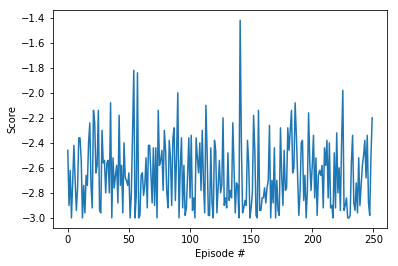

Episode 251	Average Score: -2.67Maxi 299
Episode 252	Average Score: -2.67Maxi 299
Episode 253	Average Score: -2.67Maxi 299
Episode 254	Average Score: -2.67Maxi 299

Environment solved in 155 episodes!	Average Score: -2.67
Episode 255	Average Score: -2.66Maxi 299
Episode 256	Average Score: -2.66Maxi 299
Episode 257	Average Score: -2.67Maxi 299
Episode 258	Average Score: -2.67Maxi 299
Episode 259	Average Score: -2.67Maxi 299
Episode 260	Average Score: -2.65Maxi 299
Episode 260	Average Score: -2.65


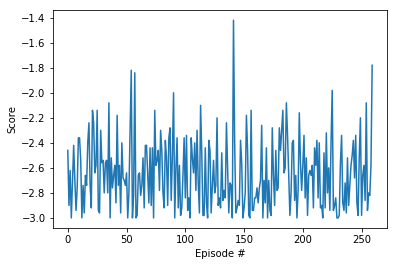

Episode 261	Average Score: -2.65Maxi 299
Episode 262	Average Score: -2.65Maxi 299
Episode 263	Average Score: -2.64Maxi 299
Episode 264	Average Score: -2.63Maxi 299
Episode 265	Average Score: -2.64Maxi 299
Episode 266	Average Score: -2.64Maxi 299
Episode 267	Average Score: -2.64Maxi 299
Episode 268	Average Score: -2.64Maxi 299
Episode 269	Average Score: -2.64Maxi 299
Episode 270	Average Score: -2.64Maxi 299
Episode 270	Average Score: -2.64


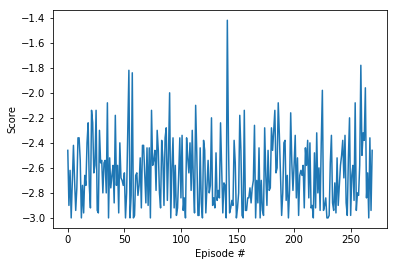

Episode 271	Average Score: -2.64Maxi 299
Episode 272	Average Score: -2.64Maxi 299
Episode 273	Average Score: -2.63Maxi 299
Episode 274	Average Score: -2.63Maxi 299
Episode 275	Average Score: -2.64Maxi 299
Episode 276	Average Score: -2.63Maxi 299
Episode 277	Average Score: -2.63Maxi 299
Episode 278	Average Score: -2.63Maxi 299
Episode 279	Average Score: -2.63Maxi 299
Episode 280	Average Score: -2.63Maxi 299
Episode 280	Average Score: -2.63


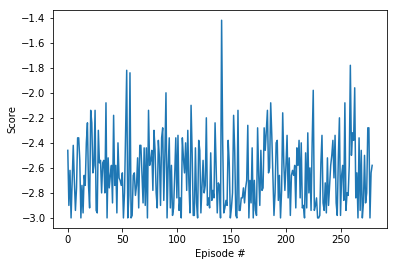

Episode 281	Average Score: -2.63Maxi 299
Episode 282	Average Score: -2.64Maxi 299
Episode 283	Average Score: -2.64Maxi 299
Episode 284	Average Score: -2.65Maxi 299
Episode 285	Average Score: -2.65Maxi 299
Episode 286	Average Score: -2.65Maxi 299
Episode 287	Average Score: -2.66Maxi 299
Episode 288	Average Score: -2.65Maxi 299
Episode 289	Average Score: -2.65Maxi 299
Episode 290	Average Score: -2.65Maxi 299
Episode 290	Average Score: -2.65


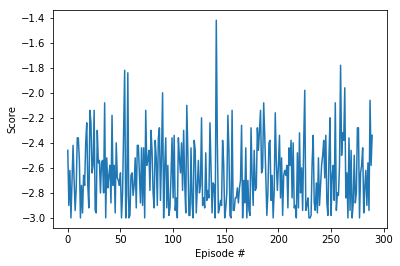

Episode 291	Average Score: -2.63Maxi 299
Episode 292	Average Score: -2.64Maxi 299
Episode 293	Average Score: -2.63Maxi 299
Episode 294	Average Score: -2.63Maxi 299
Episode 295	Average Score: -2.63Maxi 299
Episode 296	Average Score: -2.63Maxi 299
Episode 297	Average Score: -2.62Maxi 299
Episode 298	Average Score: -2.63Maxi 299
Episode 299	Average Score: -2.63Maxi 299
Episode 300	Average Score: -2.62Maxi 299
Episode 300	Average Score: -2.62


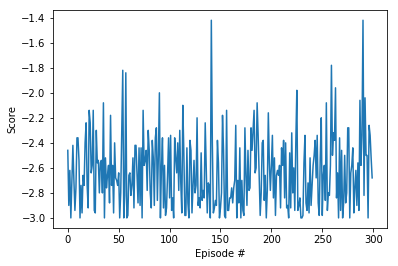

Episode 300	Average Score: -2.62


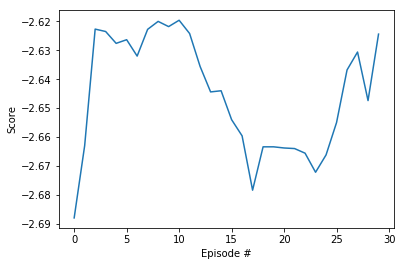

Episode 301	Average Score: -2.62Maxi 299
Episode 302	Average Score: -2.63Maxi 299
Episode 303	Average Score: -2.63Maxi 299
Episode 304	Average Score: -2.63Maxi 299

Environment solved in 205 episodes!	Average Score: -2.63
Episode 305	Average Score: -2.63Maxi 299
Episode 306	Average Score: -2.63Maxi 299
Episode 307	Average Score: -2.63Maxi 299
Episode 308	Average Score: -2.62Maxi 299
Episode 309	Average Score: -2.62Maxi 299
Episode 310	Average Score: -2.62Maxi 299
Episode 310	Average Score: -2.62


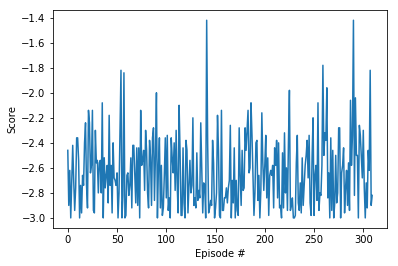

Episode 311	Average Score: -2.62Maxi 299
Episode 312	Average Score: -2.62Maxi 299
Episode 313	Average Score: -2.63Maxi 299
Episode 314	Average Score: -2.62Maxi 299
Episode 315	Average Score: -2.62Maxi 299
Episode 316	Average Score: -2.61Maxi 299
Episode 317	Average Score: -2.61Maxi 299
Episode 318	Average Score: -2.60Maxi 299
Episode 319	Average Score: -2.61Maxi 299
Episode 320	Average Score: -2.60Maxi 299
Episode 320	Average Score: -2.60


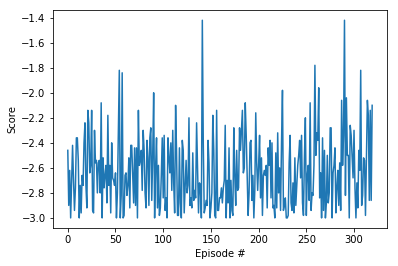

Episode 321	Average Score: -2.59Maxi 299
Episode 322	Average Score: -2.59Maxi 299
Episode 323	Average Score: -2.59Maxi 299
Episode 324	Average Score: -2.59Maxi 299
Episode 325	Average Score: -2.59Maxi 299
Episode 326	Average Score: -2.59Maxi 299
Episode 327	Average Score: -2.58Maxi 299
Episode 328	Average Score: -2.58Maxi 299
Episode 329	Average Score: -2.58Maxi 299
Episode 330	Average Score: -2.57Maxi 299
Episode 330	Average Score: -2.57


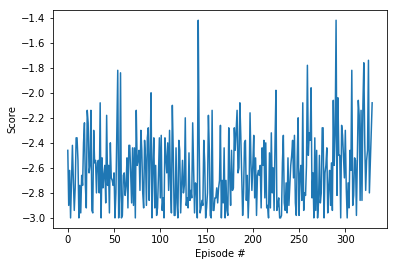

Episode 331	Average Score: -2.56Maxi 299
Episode 332	Average Score: -2.56Maxi 299
Episode 333	Average Score: -2.56Maxi 299
Episode 334	Average Score: -2.57Maxi 299
Episode 335	Average Score: -2.56Maxi 299
Episode 336	Average Score: -2.56Maxi 299
Episode 337	Average Score: -2.56Maxi 299
Episode 338	Average Score: -2.55Maxi 299
Episode 339	Average Score: -2.55Maxi 299
Episode 340	Average Score: -2.55Maxi 299
Episode 340	Average Score: -2.55


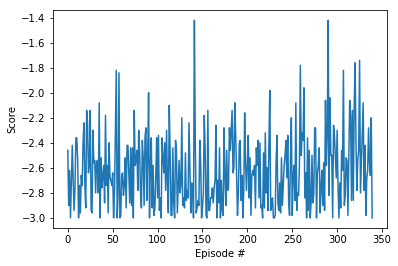

Episode 341	Average Score: -2.55Maxi 299
Episode 342	Average Score: -2.55Maxi 299
Episode 343	Average Score: -2.55Maxi 299
Episode 344	Average Score: -2.56Maxi 299
Episode 345	Average Score: -2.56Maxi 299
Episode 346	Average Score: -2.56Maxi 299
Episode 347	Average Score: -2.56Maxi 299
Episode 348	Average Score: -2.56Maxi 299
Episode 349	Average Score: -2.56Maxi 299
Episode 350	Average Score: -2.56Maxi 299
Episode 350	Average Score: -2.56


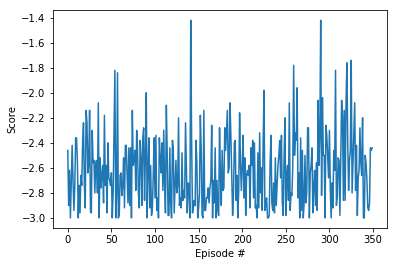

Episode 351	Average Score: -2.56Maxi 299
Episode 352	Average Score: -2.56Maxi 299
Episode 353	Average Score: -2.57Maxi 299
Episode 354	Average Score: -2.56Maxi 299

Environment solved in 255 episodes!	Average Score: -2.56
Episode 355	Average Score: -2.57Maxi 299
Episode 356	Average Score: -2.56Maxi 299
Episode 357	Average Score: -2.56Maxi 299
Episode 358	Average Score: -2.56Maxi 299
Episode 359	Average Score: -2.56Maxi 299
Episode 360	Average Score: -2.57Maxi 299
Episode 360	Average Score: -2.57


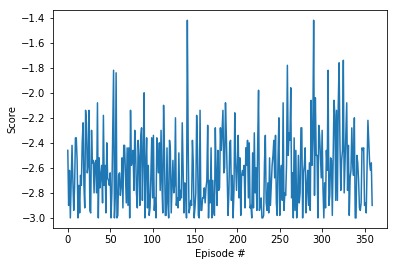

Episode 361	Average Score: -2.57Maxi 299
Episode 362	Average Score: -2.58Maxi 299
Episode 363	Average Score: -2.58Maxi 299
Episode 364	Average Score: -2.58Maxi 299
Episode 365	Average Score: -2.58Maxi 299
Episode 366	Average Score: -2.58Maxi 299
Episode 367	Average Score: -2.57Maxi 299
Episode 368	Average Score: -2.58Maxi 299
Episode 369	Average Score: -2.58Maxi 299
Episode 370	Average Score: -2.58Maxi 299
Episode 370	Average Score: -2.58


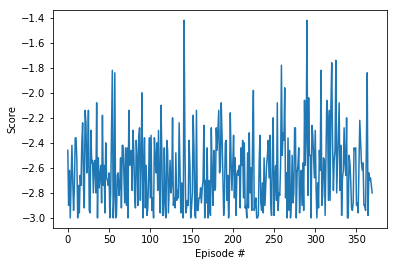

Episode 371	Average Score: -2.58Maxi 299
Episode 372	Average Score: -2.57Maxi 299
Episode 373	Average Score: -2.58Maxi 299
Episode 374	Average Score: -2.58Maxi 299
Episode 375	Average Score: -2.58Maxi 299
Episode 376	Average Score: -2.58Maxi 299
Episode 377	Average Score: -2.59Maxi 299
Episode 378	Average Score: -2.58Maxi 299
Episode 379	Average Score: -2.58Maxi 299
Episode 380	Average Score: -2.58Maxi 299
Episode 380	Average Score: -2.58


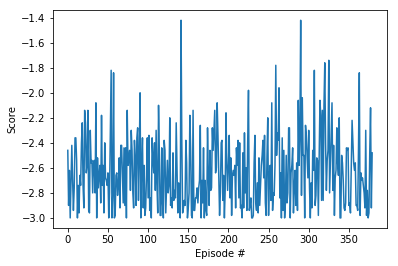

Episode 381	Average Score: -2.58Maxi 299
Episode 382	Average Score: -2.58Maxi 299
Episode 383	Average Score: -2.58Maxi 299
Episode 384	Average Score: -2.57Maxi 299
Episode 385	Average Score: -2.58Maxi 299
Episode 386	Average Score: -2.58Maxi 299
Episode 387	Average Score: -2.57Maxi 299
Episode 388	Average Score: -2.57Maxi 299
Episode 389	Average Score: -2.58Maxi 299
Episode 390	Average Score: -2.58Maxi 299
Episode 390	Average Score: -2.58


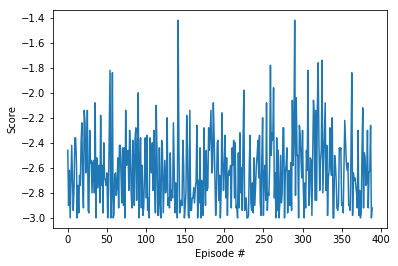

Episode 391	Average Score: -2.60Maxi 299
Episode 392	Average Score: -2.60Maxi 299
Episode 393	Average Score: -2.60Maxi 299
Episode 394	Average Score: -2.61Maxi 299
Episode 395	Average Score: -2.61Maxi 299
Episode 396	Average Score: -2.61Maxi 299
Episode 397	Average Score: -2.61Maxi 299
Episode 398	Average Score: -2.62Maxi 299
Episode 399	Average Score: -2.61Maxi 299
Episode 400	Average Score: -2.62Maxi 299
Episode 400	Average Score: -2.62


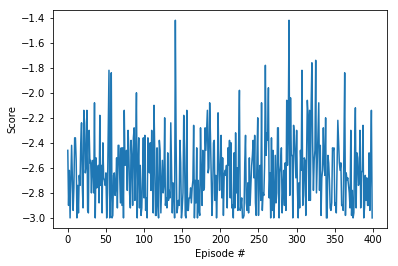

Episode 400	Average Score: -2.62


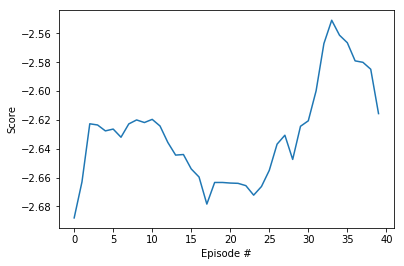

Episode 401	Average Score: -2.62Maxi 299
Episode 402	Average Score: -2.61Maxi 299
Episode 403	Average Score: -2.61Maxi 299
Episode 404	Average Score: -2.62Maxi 299

Environment solved in 305 episodes!	Average Score: -2.62
Episode 405	Average Score: -2.61Maxi 299
Episode 406	Average Score: -2.61Maxi 299
Episode 407	Average Score: -2.61Maxi 299
Episode 408	Average Score: -2.61Maxi 299
Episode 409	Average Score: -2.61Maxi 299
Episode 410	Average Score: -2.61Maxi 299
Episode 410	Average Score: -2.61


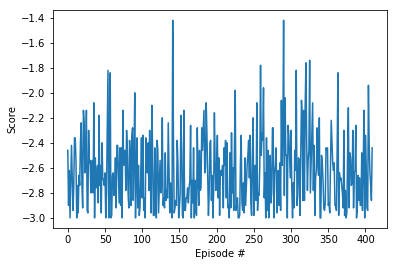

Episode 411	Average Score: -2.61Maxi 299
Episode 412	Average Score: -2.61Maxi 299
Episode 413	Average Score: -2.61Maxi 299
Episode 414	Average Score: -2.61Maxi 299
Episode 415	Average Score: -2.60Maxi 299
Episode 416	Average Score: -2.61Maxi 299
Episode 417	Average Score: -2.61Maxi 299
Episode 418	Average Score: -2.61Maxi 299
Episode 419	Average Score: -2.61Maxi 299
Episode 420	Average Score: -2.61Maxi 299
Episode 420	Average Score: -2.61


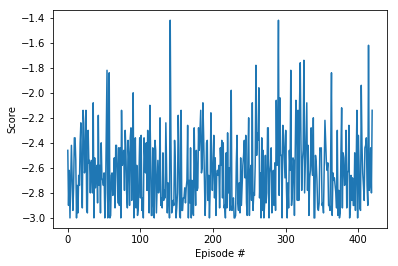

Episode 421	Average Score: -2.62Maxi 299
Episode 422	Average Score: -2.62Maxi 299
Episode 423	Average Score: -2.62Maxi 299
Episode 424	Average Score: -2.62Maxi 299
Episode 425	Average Score: -2.62Maxi 299
Episode 426	Average Score: -2.63Maxi 299
Episode 427	Average Score: -2.63Maxi 299
Episode 428	Average Score: -2.63Maxi 299
Episode 429	Average Score: -2.63Maxi 299
Episode 430	Average Score: -2.64Maxi 299
Episode 430	Average Score: -2.64


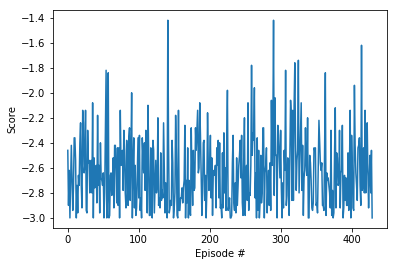

Episode 431	Average Score: -2.64Maxi 299
Episode 432	Average Score: -2.64Maxi 299
Episode 433	Average Score: -2.63Maxi 299
Episode 434	Average Score: -2.63Maxi 299
Episode 435	Average Score: -2.64Maxi 299
Episode 436	Average Score: -2.64Maxi 299
Episode 437	Average Score: -2.64Maxi 299
Episode 438	Average Score: -2.63Maxi 299
Episode 439	Average Score: -2.64Maxi 299
Episode 440	Average Score: -2.64Maxi 299
Episode 440	Average Score: -2.64


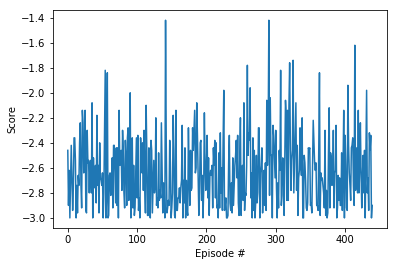

Episode 441	Average Score: -2.64Maxi 299
Episode 442	Average Score: -2.63Maxi 299
Episode 443	Average Score: -2.64Maxi 299
Episode 444	Average Score: -2.63Maxi 299
Episode 445	Average Score: -2.63Maxi 299
Episode 446	Average Score: -2.63Maxi 299
Episode 447	Average Score: -2.63Maxi 299
Episode 448	Average Score: -2.63Maxi 299
Episode 449	Average Score: -2.63Maxi 299
Episode 450	Average Score: -2.63Maxi 299
Episode 450	Average Score: -2.63


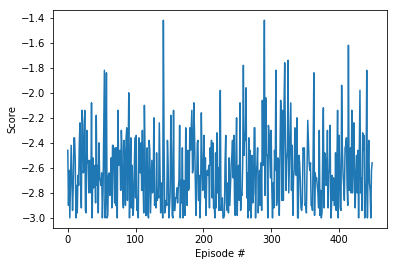

Episode 451	Average Score: -2.63Maxi 299
Episode 452	Average Score: -2.63Maxi 299
Episode 453	Average Score: -2.62Maxi 299
Episode 454	Average Score: -2.62Maxi 299

Environment solved in 355 episodes!	Average Score: -2.62
Episode 455	Average Score: -2.63Maxi 299
Episode 456	Average Score: -2.64Maxi 299
Episode 457	Average Score: -2.64Maxi 299
Episode 458	Average Score: -2.64Maxi 299
Episode 459	Average Score: -2.63Maxi 299
Episode 460	Average Score: -2.63Maxi 299
Episode 460	Average Score: -2.63


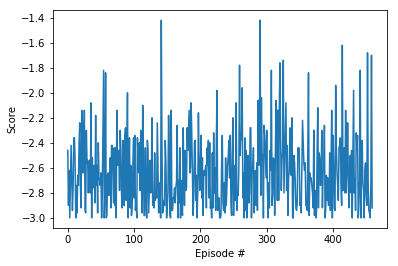

Episode 461	Average Score: -2.62Maxi 299
Episode 462	Average Score: -2.62Maxi 299
Episode 463	Average Score: -2.62Maxi 299
Episode 464	Average Score: -2.63Maxi 299
Episode 465	Average Score: -2.63Maxi 299
Episode 466	Average Score: -2.62Maxi 299
Episode 467	Average Score: -2.62Maxi 299
Episode 468	Average Score: -2.62Maxi 299
Episode 469	Average Score: -2.62Maxi 299
Episode 470	Average Score: -2.61Maxi 299
Episode 470	Average Score: -2.61


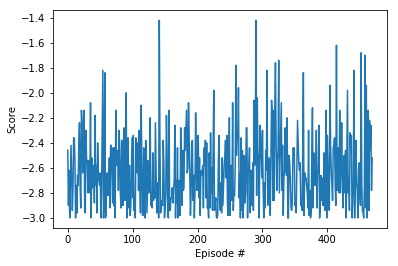

Episode 471	Average Score: -2.61Maxi 299
Episode 472	Average Score: -2.62Maxi 299
Episode 473	Average Score: -2.61Maxi 299
Episode 474	Average Score: -2.61Maxi 299
Episode 475	Average Score: -2.61Maxi 299
Episode 476	Average Score: -2.59Maxi 299
Episode 477	Average Score: -2.60Maxi 299
Episode 478	Average Score: -2.60Maxi 299
Episode 479	Average Score: -2.60Maxi 299
Episode 480	Average Score: -2.60Maxi 299
Episode 480	Average Score: -2.60


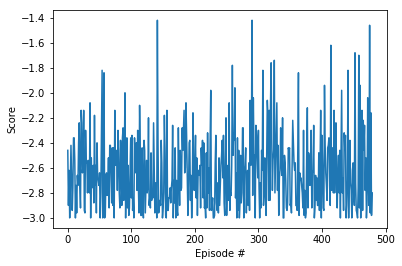

Episode 481	Average Score: -2.60Maxi 299
Episode 482	Average Score: -2.61Maxi 299
Episode 483	Average Score: -2.61Maxi 299
Episode 484	Average Score: -2.61Maxi 299
Episode 485	Average Score: -2.60Maxi 299
Episode 486	Average Score: -2.60Maxi 299
Episode 487	Average Score: -2.60Maxi 299
Episode 488	Average Score: -2.61Maxi 299
Episode 489	Average Score: -2.60Maxi 299
Episode 490	Average Score: -2.60Maxi 299
Episode 490	Average Score: -2.60


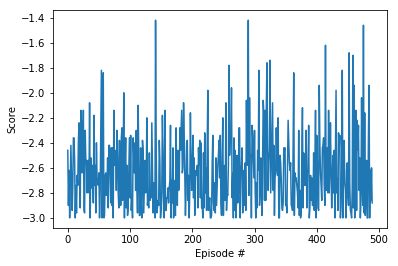

Episode 491	Average Score: -2.61Maxi 299
Episode 492	Average Score: -2.61Maxi 299
Episode 493	Average Score: -2.60Maxi 299
Episode 494	Average Score: -2.61Maxi 299
Episode 495	Average Score: -2.60Maxi 299
Episode 496	Average Score: -2.61Maxi 299
Episode 497	Average Score: -2.60Maxi 299
Episode 498	Average Score: -2.60Maxi 299
Episode 499	Average Score: -2.61Maxi 299
Episode 500	Average Score: -2.61Maxi 299
Episode 500	Average Score: -2.61


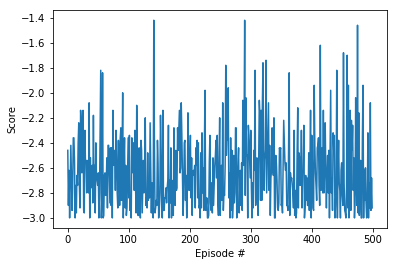

Episode 500	Average Score: -2.61


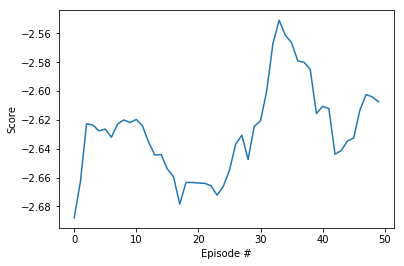

Episode 501	Average Score: -2.61Maxi 299
Episode 502	Average Score: -2.61Maxi 299
Episode 503	Average Score: -2.61Maxi 299
Episode 504	Average Score: -2.61Maxi 299

Environment solved in 405 episodes!	Average Score: -2.61
Episode 505	Average Score: -2.62Maxi 299
Episode 506	Average Score: -2.61Maxi 299
Episode 507	Average Score: -2.62Maxi 299
Episode 508	Average Score: -2.62Maxi 299
Episode 509	Average Score: -2.62Maxi 299
Episode 510	Average Score: -2.62Maxi 299
Episode 510	Average Score: -2.62


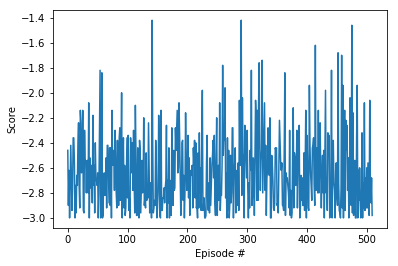

Episode 511	Average Score: -2.62Maxi 299
Episode 512	Average Score: -2.62Maxi 299
Episode 513	Average Score: -2.62Maxi 299
Episode 514	Average Score: -2.62Maxi 299
Episode 515	Average Score: -2.63Maxi 299
Episode 516	Average Score: -2.62Maxi 299
Episode 517	Average Score: -2.62Maxi 299
Episode 518	Average Score: -2.62Maxi 299
Episode 519	Average Score: -2.61Maxi 299
Episode 520	Average Score: -2.62Maxi 299
Episode 520	Average Score: -2.62


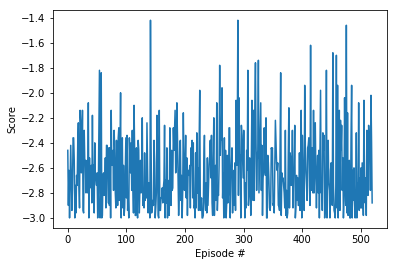

Episode 521	Average Score: -2.62Maxi 299
Episode 522	Average Score: -2.62Maxi 299
Episode 523	Average Score: -2.62Maxi 299
Episode 524	Average Score: -2.63Maxi 299
Episode 525	Average Score: -2.62Maxi 299
Episode 526	Average Score: -2.61Maxi 299
Episode 527	Average Score: -2.61Maxi 299
Episode 528	Average Score: -2.61Maxi 299
Episode 529	Average Score: -2.60Maxi 299
Episode 530	Average Score: -2.60Maxi 299
Episode 530	Average Score: -2.60


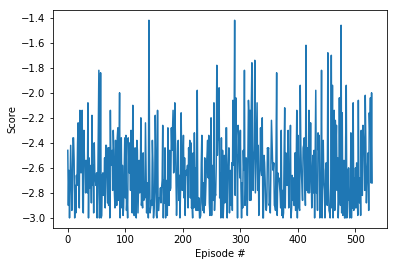

Episode 531	Average Score: -2.60Maxi 299
Episode 532	Average Score: -2.61Maxi 299
Episode 533	Average Score: -2.60Maxi 299
Episode 534	Average Score: -2.60Maxi 299
Episode 535	Average Score: -2.60Maxi 299
Episode 536	Average Score: -2.60Maxi 299
Episode 537	Average Score: -2.60Maxi 299
Episode 538	Average Score: -2.60Maxi 299
Episode 539	Average Score: -2.60Maxi 299
Episode 540	Average Score: -2.60Maxi 299
Episode 540	Average Score: -2.60


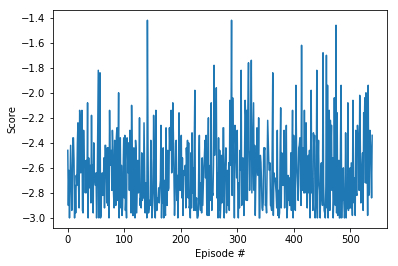

Episode 541	Average Score: -2.59Maxi 299
Episode 542	Average Score: -2.60Maxi 299
Episode 543	Average Score: -2.59Maxi 299
Episode 544	Average Score: -2.59Maxi 299
Episode 545	Average Score: -2.60Maxi 299
Episode 546	Average Score: -2.59Maxi 299
Episode 547	Average Score: -2.59Maxi 299
Episode 548	Average Score: -2.59Maxi 299
Episode 549	Average Score: -2.58Maxi 299
Episode 550	Average Score: -2.58Maxi 299
Episode 550	Average Score: -2.58


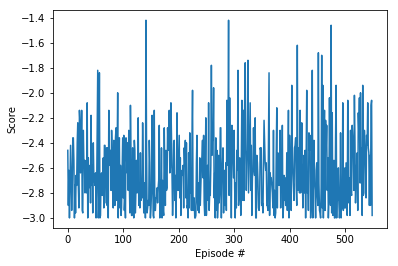

Episode 551	Average Score: -2.58Maxi 299
Episode 552	Average Score: -2.57Maxi 299
Episode 553	Average Score: -2.58Maxi 299
Episode 554	Average Score: -2.57Maxi 299

Environment solved in 455 episodes!	Average Score: -2.57
Episode 555	Average Score: -2.57Maxi 299
Episode 556	Average Score: -2.57Maxi 299
Episode 557	Average Score: -2.56Maxi 299
Episode 558	Average Score: -2.56Maxi 299
Episode 559	Average Score: -2.57Maxi 299
Episode 560	Average Score: -2.57Maxi 299
Episode 560	Average Score: -2.57


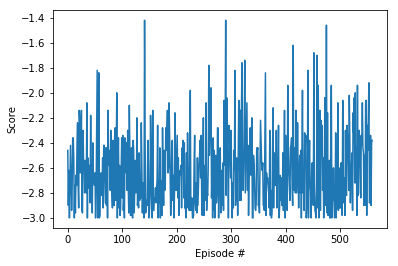

Episode 561	Average Score: -2.56Maxi 299
Episode 562	Average Score: -2.56Maxi 299
Episode 563	Average Score: -2.56Maxi 299
Episode 564	Average Score: -2.56Maxi 299
Episode 565	Average Score: -2.56Maxi 299
Episode 566	Average Score: -2.57Maxi 299
Episode 567	Average Score: -2.57Maxi 299
Episode 568	Average Score: -2.57Maxi 299
Episode 569	Average Score: -2.57Maxi 299
Episode 570	Average Score: -2.56Maxi 299
Episode 570	Average Score: -2.56


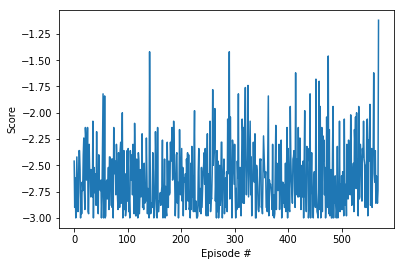

Episode 571	Average Score: -2.56Maxi 299
Episode 572	Average Score: -2.56Maxi 299
Episode 573	Average Score: -2.57Maxi 299
Episode 574	Average Score: -2.57Maxi 299
Episode 575	Average Score: -2.56Maxi 299
Episode 576	Average Score: -2.58Maxi 299
Episode 577	Average Score: -2.57Maxi 299
Episode 578	Average Score: -2.58Maxi 299
Episode 579	Average Score: -2.57Maxi 299
Episode 580	Average Score: -2.57Maxi 299
Episode 580	Average Score: -2.57


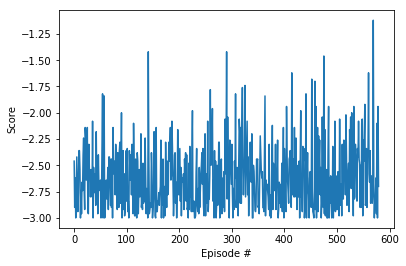

Episode 581	Average Score: -2.57Maxi 299
Episode 582	Average Score: -2.57Maxi 299
Episode 583	Average Score: -2.57Maxi 299
Episode 584	Average Score: -2.56Maxi 299
Episode 585	Average Score: -2.57Maxi 299
Episode 586	Average Score: -2.57Maxi 299
Episode 587	Average Score: -2.57Maxi 299
Episode 588	Average Score: -2.57Maxi 299
Episode 589	Average Score: -2.57Maxi 299
Episode 590	Average Score: -2.57Maxi 299
Episode 590	Average Score: -2.57


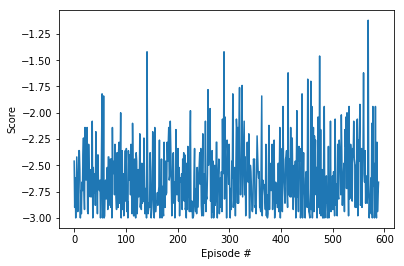

Episode 591	Average Score: -2.57Maxi 299
Episode 592	Average Score: -2.57Maxi 299
Episode 593	Average Score: -2.57Maxi 299
Episode 594	Average Score: -2.57Maxi 299
Episode 595	Average Score: -2.56Maxi 299
Episode 596	Average Score: -2.56Maxi 299
Episode 597	Average Score: -2.56Maxi 299
Episode 598	Average Score: -2.55Maxi 299
Episode 599	Average Score: -2.55Maxi 299
Episode 600	Average Score: -2.55Maxi 299
Episode 600	Average Score: -2.55


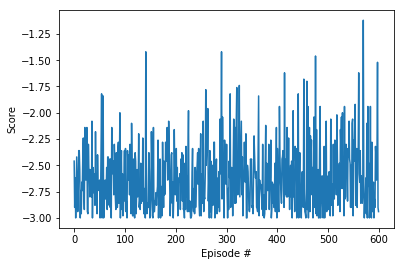

Episode 600	Average Score: -2.55


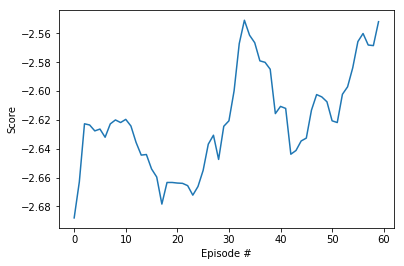

Episode 601	Average Score: -2.55Maxi 299
Episode 602	Average Score: -2.55Maxi 299
Episode 603	Average Score: -2.55Maxi 299
Episode 604	Average Score: -2.55Maxi 299

Environment solved in 505 episodes!	Average Score: -2.55
Episode 605	Average Score: -2.55Maxi 299
Episode 606	Average Score: -2.55Maxi 299
Episode 607	Average Score: -2.55Maxi 299
Episode 608	Average Score: -2.55Maxi 299
Episode 609	Average Score: -2.54Maxi 299
Episode 610	Average Score: -2.53Maxi 299
Episode 610	Average Score: -2.53


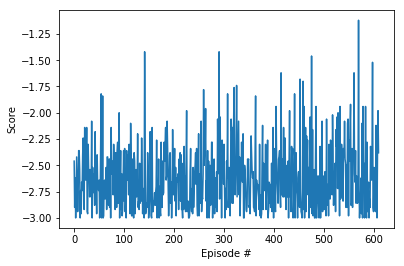

Episode 611	Average Score: -2.53Maxi 299
Episode 612	Average Score: -2.53Maxi 299
Episode 613	Average Score: -2.53Maxi 299
Episode 614	Average Score: -2.53Maxi 299
Episode 615	Average Score: -2.54Maxi 299
Episode 616	Average Score: -2.54Maxi 299
Episode 617	Average Score: -2.54Maxi 299
Episode 618	Average Score: -2.55Maxi 299
Episode 619	Average Score: -2.55Maxi 299
Episode 620	Average Score: -2.54Maxi 299
Episode 620	Average Score: -2.54


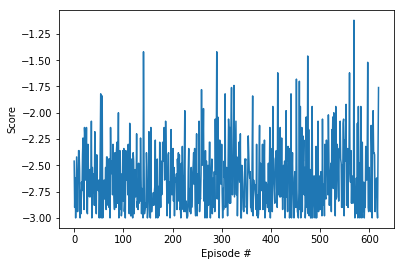

Episode 621	Average Score: -2.54Maxi 299
Episode 622	Average Score: -2.54Maxi 299
Episode 623	Average Score: -2.55Maxi 299
Episode 624	Average Score: -2.55Maxi 299
Episode 625	Average Score: -2.55Maxi 299
Episode 626	Average Score: -2.55Maxi 299
Episode 627	Average Score: -2.56Maxi 299
Episode 628	Average Score: -2.55Maxi 299
Episode 629	Average Score: -2.55Maxi 299
Episode 630	Average Score: -2.54Maxi 299
Episode 630	Average Score: -2.54


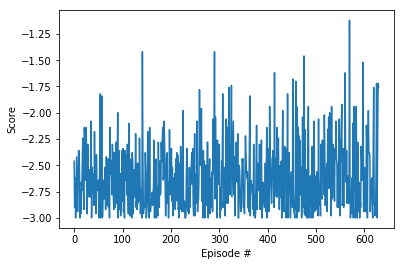

Episode 631	Average Score: -2.55Maxi 299
Episode 632	Average Score: -2.54Maxi 299
Episode 633	Average Score: -2.55Maxi 299
Episode 634	Average Score: -2.55Maxi 299
Episode 635	Average Score: -2.54Maxi 299
Episode 636	Average Score: -2.54Maxi 299
Episode 637	Average Score: -2.54Maxi 299
Episode 638	Average Score: -2.53Maxi 299
Episode 639	Average Score: -2.52Maxi 299
Episode 640	Average Score: -2.52Maxi 299
Episode 640	Average Score: -2.52


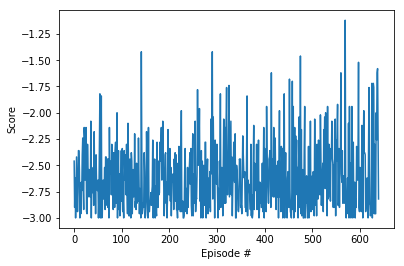

Episode 641	Average Score: -2.53Maxi 299
Episode 642	Average Score: -2.53Maxi 299
Episode 643	Average Score: -2.52Maxi 299
Episode 644	Average Score: -2.53Maxi 299
Episode 645	Average Score: -2.52Maxi 299
Episode 646	Average Score: -2.53Maxi 299
Episode 647	Average Score: -2.52Maxi 299
Episode 648	Average Score: -2.53Maxi 299
Episode 649	Average Score: -2.54Maxi 299
Episode 650	Average Score: -2.54Maxi 299
Episode 650	Average Score: -2.54


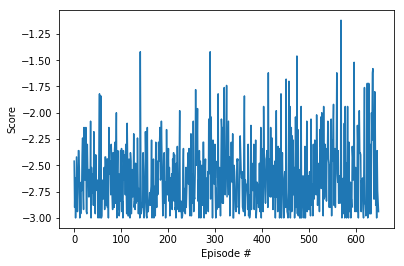

Episode 651	Average Score: -2.53Maxi 299
Episode 652	Average Score: -2.54Maxi 299
Episode 653	Average Score: -2.54Maxi 299
Episode 654	Average Score: -2.54Maxi 299

Environment solved in 555 episodes!	Average Score: -2.54
Episode 655	Average Score: -2.54Maxi 299
Episode 656	Average Score: -2.53Maxi 299
Episode 657	Average Score: -2.53Maxi 299
Episode 658	Average Score: -2.53Maxi 299
Episode 659	Average Score: -2.53Maxi 299
Episode 660	Average Score: -2.54Maxi 299
Episode 660	Average Score: -2.54


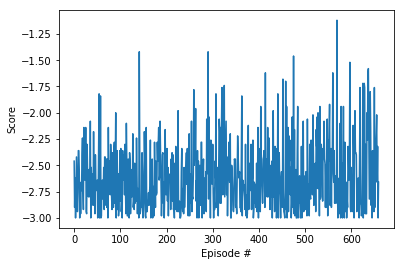

Episode 661	Average Score: -2.55Maxi 299
Episode 662	Average Score: -2.55Maxi 299
Episode 663	Average Score: -2.55Maxi 299
Episode 664	Average Score: -2.55Maxi 299
Episode 665	Average Score: -2.53Maxi 299
Episode 666	Average Score: -2.52Maxi 299
Episode 667	Average Score: -2.52Maxi 299
Episode 668	Average Score: -2.51Maxi 299
Episode 669	Average Score: -2.51Maxi 299
Episode 670	Average Score: -2.53Maxi 299
Episode 670	Average Score: -2.53


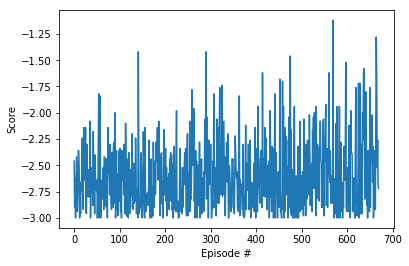

Episode 671	Average Score: -2.53Maxi 299
Episode 672	Average Score: -2.52Maxi 299
Episode 673	Average Score: -2.51Maxi 299
Episode 674	Average Score: -2.51Maxi 299
Episode 675	Average Score: -2.51Maxi 299
Episode 676	Average Score: -2.50Maxi 299
Episode 677	Average Score: -2.50Maxi 299
Episode 678	Average Score: -2.49Maxi 299
Episode 679	Average Score: -2.49Maxi 299
Episode 680	Average Score: -2.49Maxi 299
Episode 680	Average Score: -2.49


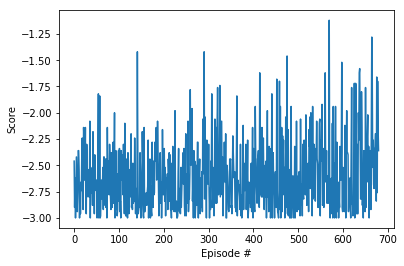

Episode 681	Average Score: -2.49Maxi 299
Episode 682	Average Score: -2.49Maxi 299
Episode 683	Average Score: -2.49Maxi 299
Episode 684	Average Score: -2.48Maxi 299
Episode 685	Average Score: -2.48Maxi 299
Episode 686	Average Score: -2.47Maxi 299
Episode 687	Average Score: -2.47Maxi 299
Episode 688	Average Score: -2.47Maxi 299
Episode 689	Average Score: -2.47Maxi 299
Episode 690	Average Score: -2.48Maxi 299
Episode 690	Average Score: -2.48


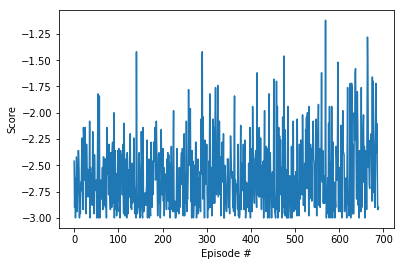

Episode 691	Average Score: -2.47Maxi 299
Episode 692	Average Score: -2.46Maxi 299
Episode 693	Average Score: -2.45Maxi 299
Episode 694	Average Score: -2.45Maxi 299
Episode 695	Average Score: -2.45Maxi 299
Episode 696	Average Score: -2.45Maxi 299
Episode 697	Average Score: -2.45Maxi 299
Episode 698	Average Score: -2.46Maxi 299
Episode 699	Average Score: -2.46Maxi 299
Episode 700	Average Score: -2.44Maxi 299
Episode 700	Average Score: -2.44


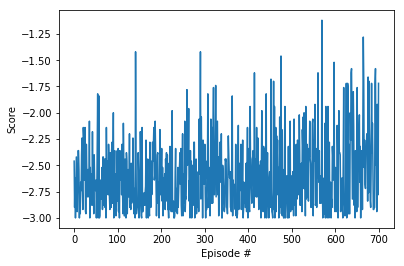

Episode 700	Average Score: -2.44


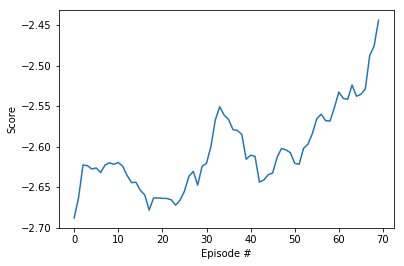

Episode 701	Average Score: -2.44Maxi 299
Episode 702	Average Score: -2.44Maxi 299
Episode 703	Average Score: -2.44Maxi 299
Episode 704	Average Score: -2.42Maxi 299

Environment solved in 605 episodes!	Average Score: -2.42
Episode 705	Average Score: -2.42Maxi 299
Episode 706	Average Score: -2.43Maxi 299
Episode 707	Average Score: -2.43Maxi 299
Episode 708	Average Score: -2.42Maxi 299
Episode 709	Average Score: -2.43Maxi 299
Episode 710	Average Score: -2.44Maxi 299
Episode 710	Average Score: -2.44


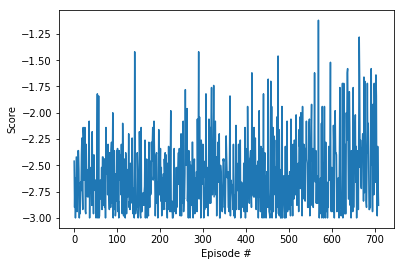

Episode 711	Average Score: -2.44Maxi 299
Episode 712	Average Score: -2.44Maxi 299
Episode 713	Average Score: -2.43Maxi 299
Episode 714	Average Score: -2.42Maxi 299
Episode 715	Average Score: -2.42Maxi 299
Episode 716	Average Score: -2.41Maxi 299
Episode 717	Average Score: -2.41Maxi 299
Episode 718	Average Score: -2.40Maxi 299
Episode 719	Average Score: -2.41Maxi 299
Episode 720	Average Score: -2.41Maxi 299
Episode 720	Average Score: -2.41


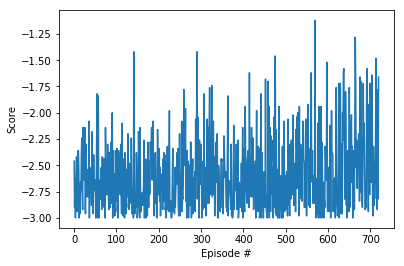

Episode 721	Average Score: -2.40Maxi 299
Episode 722	Average Score: -2.40Maxi 299
Episode 723	Average Score: -2.39Maxi 299
Episode 724	Average Score: -2.39Maxi 299
Episode 725	Average Score: -2.39Maxi 299
Episode 726	Average Score: -2.40Maxi 299
Episode 727	Average Score: -2.40Maxi 299
Episode 728	Average Score: -2.40Maxi 299
Episode 729	Average Score: -2.41Maxi 299
Episode 730	Average Score: -2.42Maxi 299
Episode 730	Average Score: -2.42


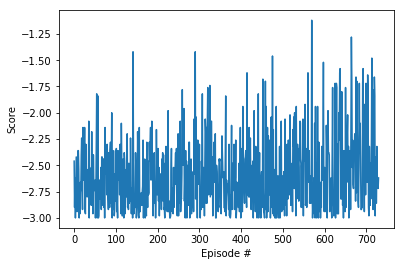

Episode 731	Average Score: -2.42Maxi 299
Episode 732	Average Score: -2.42Maxi 299
Episode 733	Average Score: -2.41Maxi 299
Episode 734	Average Score: -2.41Maxi 299
Episode 735	Average Score: -2.41Maxi 299
Episode 736	Average Score: -2.41Maxi 299
Episode 737	Average Score: -2.43Maxi 299
Episode 738	Average Score: -2.44Maxi 299
Episode 739	Average Score: -2.43Maxi 299
Episode 740	Average Score: -2.43Maxi 299
Episode 740	Average Score: -2.43


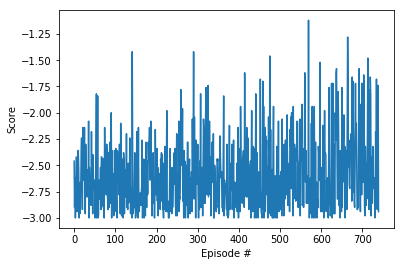

Episode 741	Average Score: -2.43Maxi 299
Episode 742	Average Score: -2.44Maxi 299
Episode 743	Average Score: -2.44Maxi 299
Episode 744	Average Score: -2.43Maxi 299
Episode 745	Average Score: -2.43Maxi 299
Episode 746	Average Score: -2.43Maxi 299
Episode 747	Average Score: -2.43Maxi 299
Episode 748	Average Score: -2.43Maxi 299
Episode 749	Average Score: -2.43Maxi 299
Episode 750	Average Score: -2.43Maxi 299
Episode 750	Average Score: -2.43


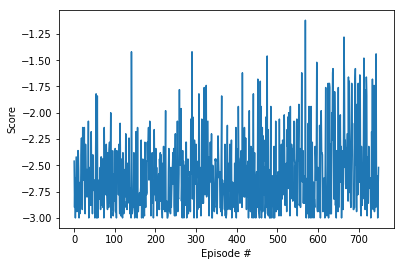

Episode 751	Average Score: -2.43Maxi 299
Episode 752	Average Score: -2.42Maxi 299
Episode 753	Average Score: -2.41Maxi 299
Episode 754	Average Score: -2.42Maxi 299

Environment solved in 655 episodes!	Average Score: -2.42
Episode 755	Average Score: -2.42Maxi 299
Episode 756	Average Score: -2.43Maxi 299
Episode 757	Average Score: -2.43Maxi 299
Episode 758	Average Score: -2.44Maxi 299
Episode 759	Average Score: -2.44Maxi 299
Episode 760	Average Score: -2.44Maxi 299
Episode 760	Average Score: -2.44


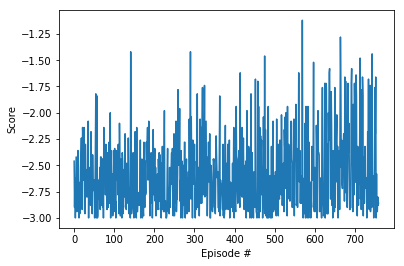

Episode 761	Average Score: -2.43Maxi 299
Episode 762	Average Score: -2.43Maxi 299
Episode 763	Average Score: -2.43Maxi 299
Episode 764	Average Score: -2.44Maxi 299
Episode 765	Average Score: -2.44Maxi 299


In [ ]:
# have to modify this according to the Gazebo sim
# did that
def dqn(n_episodes=3000, max_t=10000, eps_start=1.0, eps_end=0.01, eps_decay=0.999):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    avg_scores = []
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start# initialize epsilon
    Max_t = 0
    
    for i_episode in range(1, n_episodes+1):
        global saving_score
        global saving_episode
        if np.mean(scores_window)>= saving_score or (i_episode % saving_episode == 0 and i_episode != 0):
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_agent_at_'+str(i_episode)+'.pth')
            saving_episode += next_saving
            if np.mean(scores_window)>= saving_score:
                saving_score += next_saving_score
            if np.mean(scores_window)>=160.0:
                break
        
        
        
        observation = env.reset()
        # just using the first 5000 values of the echo sequence
        if len(observation[0]) >= 5000:
            state = [observation[0][:5000]/norm_max, observation[1][:5000]/norm_max]
        else :
            state = [handling_echo_bug(observation[0])/norm_max, handling_echo_bug(observation[1])/norm_max]
       
        score = 0
        #print("hello")
        for t in range(max_t):
            #print("state",state[0].shape)
            action = agent.act(state, eps)
            #print(action.dtype)
            action = np.int32(action)
            next_observation, reward, done, info = env.step(action)
            #assert(len(next_observation[0])> 5000), "wtf fuck is going on "+str(next_observation[0].shape)
            if len(next_observation[0]) >= 5000:
                next_state = [next_observation[0][:5000]/norm_max , next_observation[1][:5000]/norm_max]
            else :
                next_state = [handling_echo_bug(next_observation[0])/norm_max, handling_echo_bug(next_observation[1])/norm_max]
            #print("next_state",next_state[0].shape, len(next_observation), next_observation[0].shape )
            #next_state = np.resize(extract_luminance_state(env_info.visual_observations[0], peek = True) , (1,84,84))
            #print(next_state.shape)
            agent.step(state, action, reward, next_state, done)
            #print(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                Max_t = t
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        print("Maxi" ,Max_t)
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            fig = plt.figure()
            ax = fig.add_subplot(111)
            avg_scores.append(np.mean(scores_window))
            plt.plot(np.arange(len(scores)), scores)
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.show()
            
        if i_episode % 100 == 0 and i_episode != 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.plot(np.arange(len(avg_scores)), avg_scores)
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.show()
        
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


In [ ]:
print(saving_score)

In [147]:
env._close()